# Optimistic Active learning using RF - Batch Sequential Experiments - fixed initial set

### NOW, the descriptors for the whole dataset shall be generated and saved within a dataframe. Then the datapoints for initialization shall be selected and the lookup table shall be set up.




In [547]:
# import all required packages 
import math
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# for RF
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

#for GP
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,Matern, ConstantKernel as C

# for the NN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

#install package for excel support
#!pip install xlrd --user
import xlrd

import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs

In [548]:
# get the data from the excel sheet
# we import the data set which does not include the data from Ligand 29 

column_names = ['Ligand','Ligand_SMILES_chemdraw','Pd_Species','Pd_Species_SMILES','Boronic_acid','Boronic_acid_SMILES',
                'HOMO','LUMO','totale_dipole','E_RB3LYP',
                'N_sterimol_L','N_sterimol_B1','N_sterimol_B5',
                'R_sterimol_L','R_sterimol_B1','R_sterimol_B5',
                'R_only_sterimol_L','R_only_sterimol_B1','R_only_sterimol_B5',
                'NBO_N','NBO_OR','NBO__O','NBO_AcO',
                'chelpg_N','chelpg_OR','chelpg_O','chelpg_AcO',
                'V_buried',
                'N_H_proton',
                'Yield']

raw_dataset = pd.read_excel('HTE_Dataset_all_new_2.xlsx',names=column_names)

dataset = raw_dataset.copy()

# only now we can shuffle the data 
#dataset = shuffle(dataset)
print('Full dataset shape:',dataset.shape)



Full dataset shape: (186, 30)


## Let's get the features for the whole dataset ready

In [549]:
''' ----------------------- Morgan 2 Fingerprints ---------------------------'''

# Let's convert the whole list of ligand SMILES strings from the dataframe into mole files
ligands_mol_list = []

for element in dataset.Ligand_SMILES_chemdraw:
    mol = Chem.MolFromSmiles(element)
    ligands_mol_list.append(mol)

# Now let's generate Morgan Fingerprints for all of the Ligand structures
# create a list and loop over all elements in ligands_mol_list to generate Morgan Fingerprints, they are then stored in the list ligands_fp_list

ligands_fp_list = []

for element in ligands_mol_list:
    lig_fp = AllChem.GetMorganFingerprintAsBitVect(element,2,nBits=1024)
    ligands_fp_list.append(lig_fp)
    
# this still works, I get a list with all the Morgan FP

#now I want to show the Morgen FP as a np array:

ligands_fp_list_2 = []

# using a list does not really work somehow
for element in ligands_fp_list:
    ligands_fp_list_array = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(element,ligands_fp_list_array)
    ligands_fp_list_2.append(ligands_fp_list_array)

    
#print(len(ligands_fp_list_2))
# This is the list containing the Morgan Fingerprints of all ligands
#print(ligands_fp_list_2)

# Let's convert the Pd species from the dataframe into mole files and then Fingerprints like with the ligands

Pd_mol_list = []

for element in dataset.Pd_Species_SMILES:
    mol = Chem.MolFromSmiles(element)
    Pd_mol_list.append(mol)


# Now let's generate Morgan Fingerprints for all of the Pd species structures

Pd_fp_list = []

for element in Pd_mol_list:
    Pd_fp = AllChem.GetMorganFingerprintAsBitVect(element,2,nBits=1024)
    Pd_fp_list.append(Pd_fp)
    
Pd_fp_list_2 = []

for element in Pd_fp_list:
    Pd_fp_list_array = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(element,Pd_fp_list_array)
    Pd_fp_list_2.append(Pd_fp_list_array)


# This is the list containing the Morgan Fingerprints of the Pd species
# print(Pd_fp_list_2)  

# Let's convert the Boronic acid from the dataframe into mole files and then into Morgan Fingerprints

Boronic_acid_mol_list = []

for element in dataset.Boronic_acid_SMILES:
    mol = Chem.MolFromSmiles(element)
    Boronic_acid_mol_list.append(mol)

# Now let's generate Morgan Fingerprints for all of the Pd species structures

Boronic_acid_fp_list = []

for element in Boronic_acid_mol_list:
    Boronic_acid_fp = AllChem.GetMorganFingerprintAsBitVect(element,2,nBits=1024)
    Boronic_acid_fp_list.append(Boronic_acid_fp)
    
Boronic_acid_fp_list_2 = []

for element in Boronic_acid_fp_list:
    Boronic_acid_fp_list_array = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(element,Boronic_acid_fp_list_array)
    Boronic_acid_fp_list_2.append(Boronic_acid_fp_list_array)


# This is the list containing the Morgan Fingerprints of the Boronic acids species
# print(Boronic_acid_fp_list_2)  

'''Now we want to map the three tables (containint the bit vectors of the single molecules, 
as arrays) to the yield (output) in order to then use it for the ML model'''

# At first we generate np arrays from the lists

ligands_fp_list_2 = np.array(ligands_fp_list_2)
# print(ligands_fp_list_2.shape)

Pd_fp_list_2 = np.array(Pd_fp_list_2)
# print(Pd_fp_list_2.shape)

Boronic_acid_fp_list_2 = np.array(Boronic_acid_fp_list_2)
# print(Boronic_acid_fp_list_2.shape)

# add all fingerprints together

x = np.append(ligands_fp_list_2,Pd_fp_list_2,axis=1)
fingerprints_input = np.append(x,Boronic_acid_fp_list_2,axis=1)

print('Lookup table: shape of the fingerprint input:',fingerprints_input.shape)

''' ----------------------- PCA of Morgan FP --------------------------'''

pca = PCA(n_components=30)
#pca = PCA(0.95)

pca_ligands = pca.fit_transform(ligands_fp_list_2)
#print(pca_ligands.shape)
pca_precat = pca.fit_transform(Pd_fp_list_2)
#print(pca_precat.shape)
pca_boronic = pca.fit_transform(Boronic_acid_fp_list_2)
#print(pca_boronic.shape)
# print(pca_ligands.shape)
# print(pca_precat.shape)
# print(pca_boronic.shape)

fp_pca_data = np.append(pca_ligands,pca_precat,axis=1)
fp_pca_data = np.append(fp_pca_data,pca_boronic,axis=1)

#print(pca.explained_variance_ratio_)

print('Lookup table: shape of the PCA fingerprints:',fp_pca_data.shape)

'''------------------------   One-hot encoding ------------------------'''
# convert the discrete data into one-hot encoding

ligand_onehot = pd.get_dummies(dataset['Ligand'], prefix="ligand")
precat_onehot = pd.get_dummies(dataset['Pd_Species'], prefix="precat")
boronic_acid_onehot = pd.get_dummies(dataset['Boronic_acid'], prefix="boronic_acid")

# print(ligand_onehot.shape)
# print(precat_onehot.shape)
# print(boronic_acid_onehot.shape)

# let's concatenate the single dataframes (the ligands are excluded for the beginning)

# combined = [ligand_onehot,precat_onehot,boronic_acid_onehot]
combined = [ligand_onehot,precat_onehot,boronic_acid_onehot]
combined_small = [precat_onehot,boronic_acid_onehot]


dataset_one_hot = pd.concat(combined, axis=1)
dataset_one_hot_small = pd.concat(combined_small, axis=1)

#print('shape of the one-hot encoding:',dataset_one_hot.shape)
print('Lookup table: shape of the small one-hot encoding:',dataset_one_hot_small.shape)
print('Lookup table: shape of the  one-hot encoding:',dataset_one_hot.shape)


'''------------------------   DFT input ------------------------'''

# now we still need to add the information from the DFT descriptors 

homo = np.array(dataset.HOMO).reshape(-1,1)
# print(homo.shape)

lumo = np.array(dataset.LUMO).reshape(-1,1)
# print(lumo.shape)

total_dipole = np.array(dataset.totale_dipole).reshape(-1,1)
# print(total_dipole.shape)

E_RB3LYP = np.array(dataset.E_RB3LYP).reshape(-1,1)
# print(E_RB3LYP.shape)

# let's capture the DFT data in one separat array so that we can later add it easier to the other Morgan FP data

dft_data = np.append(homo,lumo,axis=1)

print('Lookup table: shape of the dfp input:',dft_data.shape)
#print('shape of the small dfp input:',dft_data_small.shape)

'''------------------------   Sterimol input ------------------------'''

# now we still need to add the information from the sterimol descriptors 

N_sterimol_l = dataset.N_sterimol_L
N_sterimol_b1 = dataset.N_sterimol_L
N_sterimol_b5 = dataset.N_sterimol_L

R_sterimol_l = dataset.R_sterimol_L
R_sterimol_b1 = dataset.R_sterimol_L
R_sterimol_b5 = dataset.R_sterimol_L

sterimol_combined = [N_sterimol_l,N_sterimol_b1,N_sterimol_b5,R_sterimol_l,R_sterimol_b1,R_sterimol_b5]
data_2_sterimol = pd.concat(sterimol_combined, axis=1)

print('Lookup table: shape of the simle sterimol input:',data_2_sterimol.shape)

R_only_sterimol_l = dataset.R_only_sterimol_L
R_only_sterimol_b1 = dataset.R_only_sterimol_L
R_only_sterimol_b5 = dataset.R_only_sterimol_L

sterimol_only_residue_combined = [R_only_sterimol_l,R_only_sterimol_b1,R_only_sterimol_b5]
data_only_R_sterimol = pd.concat(sterimol_only_residue_combined, axis=1)

print('Lookup table: shape of the isolated residue sterimol input:',data_only_R_sterimol.shape)

'''------------------------   NBO input ------------------------'''

# get the NBO data ready

NBO_N = np.array(dataset.NBO_N).reshape(-1,1)
NBO_OR = np.array(dataset.NBO_OR).reshape(-1,1)
NBO_O__ = np.array(dataset.NBO__O).reshape(-1,1)
NBO_AcO = np.array(dataset.NBO_AcO).reshape(-1,1)

NBO_data = np.append(NBO_N,NBO_OR,axis=1)
NBO_data = np.append(NBO_data,NBO_O__,axis=1)
NBO_data = np.append(NBO_data,NBO_AcO,axis=1)

print('Lookup table: shape of the NBO input:',NBO_data.shape)

'''------------------------   CHELPG input ------------------------'''

# get the chelpg data ready

chelpg_N = dataset.chelpg_N
chelpg_OR = dataset.chelpg_OR
chelpg_O = dataset.chelpg_O
chelpg_AcO = dataset.chelpg_AcO

chelpg_combined = [chelpg_N,chelpg_OR,chelpg_O,chelpg_AcO]
chelpg_data = pd.concat(chelpg_combined, axis=1)

print('Lookup table: shape of the chelpg input:',chelpg_data.shape)

'''------------------------   Percentage burried volume input ------------------------'''

# percentage buried volume

vol_bur = np.array(dataset.V_buried).reshape(-1,1)
print('Lookup table: shape of the percentage buried volume input:',vol_bur.shape)

'''------------------------   N - Proton volume input ------------------------'''

# existence of the proton on the nitrogen

n_proton = np.array(dataset.N_H_proton).reshape(-1,1)
print('Lookup table: shape of the N-proton input:',n_proton.shape)

'''------------------------   yield ------------------------'''

yield_numerical = np.array(dataset.Yield).reshape(-1,1)
print('Lookup table: shape of the yield input:',yield_numerical.shape)

print('M aximum yield in the training data',np.max(yield_numerical))

Lookup table: shape of the fingerprint input: (186, 3072)
Lookup table: shape of the PCA fingerprints: (186, 90)
Lookup table: shape of the small one-hot encoding: (186, 5)
Lookup table: shape of the  one-hot encoding: (186, 36)
Lookup table: shape of the dfp input: (186, 2)
Lookup table: shape of the simle sterimol input: (186, 6)
Lookup table: shape of the isolated residue sterimol input: (186, 3)
Lookup table: shape of the NBO input: (186, 4)
Lookup table: shape of the chelpg input: (186, 4)
Lookup table: shape of the percentage buried volume input: (186, 1)
Lookup table: shape of the N-proton input: (186, 1)
Lookup table: shape of the yield input: (186, 1)
M aximum yield in the training data 0.9996579247288029


In [550]:
#FP_columns = ['1',' 2',' 3',' 4',' 5',' 6',' 7',' 8',' 9',' 10',' 11',' 12',' 13',' 14',' 15',' 16',' 17',' 18',' 19',' 20',' 21',' 22',' 23',' 24',' 25',' 26',' 27',' 28',' 29',' 30',' 31',' 32',' 33',' 34',' 35',' 36',' 37',' 38',' 39',' 40',' 41',' 42',' 43',' 44',' 45',' 46',' 47',' 48',' 49',' 50',' 51',' 52',' 53',' 54',' 55',' 56',' 57',' 58',' 59',' 60',' 61',' 62',' 63',' 64',' 65',' 66',' 67',' 68',' 69',' 70',' 71',' 72',' 73',' 74',' 75',' 76',' 77',' 78',' 79',' 80',' 81',' 82',' 83',' 84',' 85',' 86',' 87',' 88',' 89',' 90',' 91',' 92',' 93',' 94',' 95',' 96',' 97',' 98',' 99',' 100',' 101',' 102',' 103',' 104',' 105',' 106',' 107',' 108',' 109',' 110',' 111',' 112',' 113',' 114',' 115',' 116',' 117',' 118',' 119',' 120',' 121',' 122',' 123',' 124',' 125',' 126',' 127',' 128',' 129',' 130',' 131',' 132',' 133',' 134',' 135',' 136',' 137',' 138',' 139',' 140',' 141',' 142',' 143',' 144',' 145',' 146',' 147',' 148',' 149',' 150',' 151',' 152',' 153',' 154',' 155',' 156',' 157',' 158',' 159',' 160',' 161',' 162',' 163',' 164',' 165',' 166',' 167',' 168',' 169',' 170',' 171',' 172',' 173',' 174',' 175',' 176',' 177',' 178',' 179',' 180',' 181',' 182',' 183',' 184',' 185',' 186',' 187',' 188',' 189',' 190',' 191',' 192',' 193',' 194',' 195',' 196',' 197',' 198',' 199',' 200',' 201',' 202',' 203',' 204',' 205',' 206',' 207',' 208',' 209',' 210',' 211',' 212',' 213',' 214',' 215',' 216',' 217',' 218',' 219',' 220',' 221',' 222',' 223',' 224',' 225',' 226',' 227',' 228',' 229',' 230',' 231',' 232',' 233',' 234',' 235',' 236',' 237',' 238',' 239',' 240',' 241',' 242',' 243',' 244',' 245',' 246',' 247',' 248',' 249',' 250',' 251',' 252',' 253',' 254',' 255',' 256',' 257',' 258',' 259',' 260',' 261',' 262',' 263',' 264',' 265',' 266',' 267',' 268',' 269',' 270',' 271',' 272',' 273',' 274',' 275',' 276',' 277',' 278',' 279',' 280',' 281',' 282',' 283',' 284',' 285',' 286',' 287',' 288',' 289',' 290',' 291',' 292',' 293',' 294',' 295',' 296',' 297',' 298',' 299',' 300',' 301',' 302',' 303',' 304',' 305',' 306',' 307',' 308',' 309',' 310',' 311',' 312',' 313',' 314',' 315',' 316',' 317',' 318',' 319',' 320',' 321',' 322',' 323',' 324',' 325',' 326',' 327',' 328',' 329',' 330',' 331',' 332',' 333',' 334',' 335',' 336',' 337',' 338',' 339',' 340',' 341',' 342',' 343',' 344',' 345',' 346',' 347',' 348',' 349',' 350',' 351',' 352',' 353',' 354',' 355',' 356',' 357',' 358',' 359',' 360',' 361',' 362',' 363',' 364',' 365',' 366',' 367',' 368',' 369',' 370',' 371',' 372',' 373',' 374',' 375',' 376',' 377',' 378',' 379',' 380',' 381',' 382',' 383',' 384',' 385',' 386',' 387',' 388',' 389',' 390',' 391',' 392',' 393',' 394',' 395',' 396',' 397',' 398',' 399',' 400',' 401',' 402',' 403',' 404',' 405',' 406',' 407',' 408',' 409',' 410',' 411',' 412',' 413',' 414',' 415',' 416',' 417',' 418',' 419',' 420',' 421',' 422',' 423',' 424',' 425',' 426',' 427',' 428',' 429',' 430',' 431',' 432',' 433',' 434',' 435',' 436',' 437',' 438',' 439',' 440',' 441',' 442',' 443',' 444',' 445',' 446',' 447',' 448',' 449',' 450',' 451',' 452',' 453',' 454',' 455',' 456',' 457',' 458',' 459',' 460',' 461',' 462',' 463',' 464',' 465',' 466',' 467',' 468',' 469',' 470',' 471',' 472',' 473',' 474',' 475',' 476',' 477',' 478',' 479',' 480',' 481',' 482',' 483',' 484',' 485',' 486',' 487',' 488',' 489',' 490',' 491',' 492',' 493',' 494',' 495',' 496',' 497',' 498',' 499',' 500',' 501',' 502',' 503',' 504',' 505',' 506',' 507',' 508',' 509',' 510',' 511',' 512',' 513',' 514',' 515',' 516',' 517',' 518',' 519',' 520',' 521',' 522',' 523',' 524',' 525',' 526',' 527',' 528',' 529',' 530',' 531',' 532',' 533',' 534',' 535',' 536',' 537',' 538',' 539',' 540',' 541',' 542',' 543',' 544',' 545',' 546',' 547',' 548',' 549',' 550',' 551',' 552',' 553',' 554',' 555',' 556',' 557',' 558',' 559',' 560',' 561',' 562',' 563',' 564',' 565',' 566',' 567',' 568',' 569',' 570',' 571',' 572',' 573',' 574',' 575',' 576',' 577',' 578',' 579',' 580',' 581',' 582',' 583',' 584',' 585',' 586',' 587',' 588',' 589',' 590',' 591',' 592',' 593',' 594',' 595',' 596',' 597',' 598',' 599',' 600',' 601',' 602',' 603',' 604',' 605',' 606',' 607',' 608',' 609',' 610',' 611',' 612',' 613',' 614',' 615',' 616',' 617',' 618',' 619',' 620',' 621',' 622',' 623',' 624',' 625',' 626',' 627',' 628',' 629',' 630',' 631',' 632',' 633',' 634',' 635',' 636',' 637',' 638',' 639',' 640',' 641',' 642',' 643',' 644',' 645',' 646',' 647',' 648',' 649',' 650',' 651',' 652',' 653',' 654',' 655',' 656',' 657',' 658',' 659',' 660',' 661',' 662',' 663',' 664',' 665',' 666',' 667',' 668',' 669',' 670',' 671',' 672',' 673',' 674',' 675',' 676',' 677',' 678',' 679',' 680',' 681',' 682',' 683',' 684',' 685',' 686',' 687',' 688',' 689',' 690',' 691',' 692',' 693',' 694',' 695',' 696',' 697',' 698',' 699',' 700',' 701',' 702',' 703',' 704',' 705',' 706',' 707',' 708',' 709',' 710',' 711',' 712',' 713',' 714',' 715',' 716',' 717',' 718',' 719',' 720',' 721',' 722',' 723',' 724',' 725',' 726',' 727',' 728',' 729',' 730',' 731',' 732',' 733',' 734',' 735',' 736',' 737',' 738',' 739',' 740',' 741',' 742',' 743',' 744',' 745',' 746',' 747',' 748',' 749',' 750',' 751',' 752',' 753',' 754',' 755',' 756',' 757',' 758',' 759',' 760',' 761',' 762',' 763',' 764',' 765',' 766',' 767',' 768',' 769',' 770',' 771',' 772',' 773',' 774',' 775',' 776',' 777',' 778',' 779',' 780',' 781',' 782',' 783',' 784',' 785',' 786',' 787',' 788',' 789',' 790',' 791',' 792',' 793',' 794',' 795',' 796',' 797',' 798',' 799',' 800',' 801',' 802',' 803',' 804',' 805',' 806',' 807',' 808',' 809',' 810',' 811',' 812',' 813',' 814',' 815',' 816',' 817',' 818',' 819',' 820',' 821',' 822',' 823',' 824',' 825',' 826',' 827',' 828',' 829',' 830',' 831',' 832',' 833',' 834',' 835',' 836',' 837',' 838',' 839',' 840',' 841',' 842',' 843',' 844',' 845',' 846',' 847',' 848',' 849',' 850',' 851',' 852',' 853',' 854',' 855',' 856',' 857',' 858',' 859',' 860',' 861',' 862',' 863',' 864',' 865',' 866',' 867',' 868',' 869',' 870',' 871',' 872',' 873',' 874',' 875',' 876',' 877',' 878',' 879',' 880',' 881',' 882',' 883',' 884',' 885',' 886',' 887',' 888',' 889',' 890',' 891',' 892',' 893',' 894',' 895',' 896',' 897',' 898',' 899',' 900',' 901',' 902',' 903',' 904',' 905',' 906',' 907',' 908',' 909',' 910',' 911',' 912',' 913',' 914',' 915',' 916',' 917',' 918',' 919',' 920',' 921',' 922',' 923',' 924',' 925',' 926',' 927',' 928',' 929',' 930',' 931',' 932',' 933',' 934',' 935',' 936',' 937',' 938',' 939',' 940',' 941',' 942',' 943',' 944',' 945',' 946',' 947',' 948',' 949',' 950',' 951',' 952',' 953',' 954',' 955',' 956',' 957',' 958',' 959',' 960',' 961',' 962',' 963',' 964',' 965',' 966',' 967',' 968',' 969',' 970',' 971',' 972',' 973',' 974',' 975',' 976',' 977',' 978',' 979',' 980',' 981',' 982',' 983',' 984',' 985',' 986',' 987',' 988',' 989',' 990',' 991',' 992',' 993',' 994',' 995',' 996',' 997',' 998',' 999',' 1000',' 1001',' 1002',' 1003',' 1004',' 1005',' 1006',' 1007',' 1008',' 1009',' 1010',' 1011',' 1012',' 1013',' 1014',' 1015',' 1016',' 1017',' 1018',' 1019',' 1020',' 1021',' 1022',' 1023',' 1024',' 1025',' 1026',' 1027',' 1028',' 1029',' 1030',' 1031',' 1032',' 1033',' 1034',' 1035',' 1036',' 1037',' 1038',' 1039',' 1040',' 1041',' 1042',' 1043',' 1044',' 1045',' 1046',' 1047',' 1048',' 1049',' 1050',' 1051',' 1052',' 1053',' 1054',' 1055',' 1056',' 1057',' 1058',' 1059',' 1060',' 1061',' 1062',' 1063',' 1064',' 1065',' 1066',' 1067',' 1068',' 1069',' 1070',' 1071',' 1072',' 1073',' 1074',' 1075',' 1076',' 1077',' 1078',' 1079',' 1080',' 1081',' 1082',' 1083',' 1084',' 1085',' 1086',' 1087',' 1088',' 1089',' 1090',' 1091',' 1092',' 1093',' 1094',' 1095',' 1096',' 1097',' 1098',' 1099',' 1100',' 1101',' 1102',' 1103',' 1104',' 1105',' 1106',' 1107',' 1108',' 1109',' 1110',' 1111',' 1112',' 1113',' 1114',' 1115',' 1116',' 1117',' 1118',' 1119',' 1120',' 1121',' 1122',' 1123',' 1124',' 1125',' 1126',' 1127',' 1128',' 1129',' 1130',' 1131',' 1132',' 1133',' 1134',' 1135',' 1136',' 1137',' 1138',' 1139',' 1140',' 1141',' 1142',' 1143',' 1144',' 1145',' 1146',' 1147',' 1148',' 1149',' 1150',' 1151',' 1152',' 1153',' 1154',' 1155',' 1156',' 1157',' 1158',' 1159',' 1160',' 1161',' 1162',' 1163',' 1164',' 1165',' 1166',' 1167',' 1168',' 1169',' 1170',' 1171',' 1172',' 1173',' 1174',' 1175',' 1176',' 1177',' 1178',' 1179',' 1180',' 1181',' 1182',' 1183',' 1184',' 1185',' 1186',' 1187',' 1188',' 1189',' 1190',' 1191',' 1192',' 1193',' 1194',' 1195',' 1196',' 1197',' 1198',' 1199',' 1200',' 1201',' 1202',' 1203',' 1204',' 1205',' 1206',' 1207',' 1208',' 1209',' 1210',' 1211',' 1212',' 1213',' 1214',' 1215',' 1216',' 1217',' 1218',' 1219',' 1220',' 1221',' 1222',' 1223',' 1224',' 1225',' 1226',' 1227',' 1228',' 1229',' 1230',' 1231',' 1232',' 1233',' 1234',' 1235',' 1236',' 1237',' 1238',' 1239',' 1240',' 1241',' 1242',' 1243',' 1244',' 1245',' 1246',' 1247',' 1248',' 1249',' 1250',' 1251',' 1252',' 1253',' 1254',' 1255',' 1256',' 1257',' 1258',' 1259',' 1260',' 1261',' 1262',' 1263',' 1264',' 1265',' 1266',' 1267',' 1268',' 1269',' 1270',' 1271',' 1272',' 1273',' 1274',' 1275',' 1276',' 1277',' 1278',' 1279',' 1280',' 1281',' 1282',' 1283',' 1284',' 1285',' 1286',' 1287',' 1288',' 1289',' 1290',' 1291',' 1292',' 1293',' 1294',' 1295',' 1296',' 1297',' 1298',' 1299',' 1300',' 1301',' 1302',' 1303',' 1304',' 1305',' 1306',' 1307',' 1308',' 1309',' 1310',' 1311',' 1312',' 1313',' 1314',' 1315',' 1316',' 1317',' 1318',' 1319',' 1320',' 1321',' 1322',' 1323',' 1324',' 1325',' 1326',' 1327',' 1328',' 1329',' 1330',' 1331',' 1332',' 1333',' 1334',' 1335',' 1336',' 1337',' 1338',' 1339',' 1340',' 1341',' 1342',' 1343',' 1344',' 1345',' 1346',' 1347',' 1348',' 1349',' 1350',' 1351',' 1352',' 1353',' 1354',' 1355',' 1356',' 1357',' 1358',' 1359',' 1360',' 1361',' 1362',' 1363',' 1364',' 1365',' 1366',' 1367',' 1368',' 1369',' 1370',' 1371',' 1372',' 1373',' 1374',' 1375',' 1376',' 1377',' 1378',' 1379',' 1380',' 1381',' 1382',' 1383',' 1384',' 1385',' 1386',' 1387',' 1388',' 1389',' 1390',' 1391',' 1392',' 1393',' 1394',' 1395',' 1396',' 1397',' 1398',' 1399',' 1400',' 1401',' 1402',' 1403',' 1404',' 1405',' 1406',' 1407',' 1408',' 1409',' 1410',' 1411',' 1412',' 1413',' 1414',' 1415',' 1416',' 1417',' 1418',' 1419',' 1420',' 1421',' 1422',' 1423',' 1424',' 1425',' 1426',' 1427',' 1428',' 1429',' 1430',' 1431',' 1432',' 1433',' 1434',' 1435',' 1436',' 1437',' 1438',' 1439',' 1440',' 1441',' 1442',' 1443',' 1444',' 1445',' 1446',' 1447',' 1448',' 1449',' 1450',' 1451',' 1452',' 1453',' 1454',' 1455',' 1456',' 1457',' 1458',' 1459',' 1460',' 1461',' 1462',' 1463',' 1464',' 1465',' 1466',' 1467',' 1468',' 1469',' 1470',' 1471',' 1472',' 1473',' 1474',' 1475',' 1476',' 1477',' 1478',' 1479',' 1480',' 1481',' 1482',' 1483',' 1484',' 1485',' 1486',' 1487',' 1488',' 1489',' 1490',' 1491',' 1492',' 1493',' 1494',' 1495',' 1496',' 1497',' 1498',' 1499',' 1500',' 1501',' 1502',' 1503',' 1504',' 1505',' 1506',' 1507',' 1508',' 1509',' 1510',' 1511',' 1512',' 1513',' 1514',' 1515',' 1516',' 1517',' 1518',' 1519',' 1520',' 1521',' 1522',' 1523',' 1524',' 1525',' 1526',' 1527',' 1528',' 1529',' 1530',' 1531',' 1532',' 1533',' 1534',' 1535',' 1536',' 1537',' 1538',' 1539',' 1540',' 1541',' 1542',' 1543',' 1544',' 1545',' 1546',' 1547',' 1548',' 1549',' 1550',' 1551',' 1552',' 1553',' 1554',' 1555',' 1556',' 1557',' 1558',' 1559',' 1560',' 1561',' 1562',' 1563',' 1564',' 1565',' 1566',' 1567',' 1568',' 1569',' 1570',' 1571',' 1572',' 1573',' 1574',' 1575',' 1576',' 1577',' 1578',' 1579',' 1580',' 1581',' 1582',' 1583',' 1584',' 1585',' 1586',' 1587',' 1588',' 1589',' 1590',' 1591',' 1592',' 1593',' 1594',' 1595',' 1596',' 1597',' 1598',' 1599',' 1600',' 1601',' 1602',' 1603',' 1604',' 1605',' 1606',' 1607',' 1608',' 1609',' 1610',' 1611',' 1612',' 1613',' 1614',' 1615',' 1616',' 1617',' 1618',' 1619',' 1620',' 1621',' 1622',' 1623',' 1624',' 1625',' 1626',' 1627',' 1628',' 1629',' 1630',' 1631',' 1632',' 1633',' 1634',' 1635',' 1636',' 1637',' 1638',' 1639',' 1640',' 1641',' 1642',' 1643',' 1644',' 1645',' 1646',' 1647',' 1648',' 1649',' 1650',' 1651',' 1652',' 1653',' 1654',' 1655',' 1656',' 1657',' 1658',' 1659',' 1660',' 1661',' 1662',' 1663',' 1664',' 1665',' 1666',' 1667',' 1668',' 1669',' 1670',' 1671',' 1672',' 1673',' 1674',' 1675',' 1676',' 1677',' 1678',' 1679',' 1680',' 1681',' 1682',' 1683',' 1684',' 1685',' 1686',' 1687',' 1688',' 1689',' 1690',' 1691',' 1692',' 1693',' 1694',' 1695',' 1696',' 1697',' 1698',' 1699',' 1700',' 1701',' 1702',' 1703',' 1704',' 1705',' 1706',' 1707',' 1708',' 1709',' 1710',' 1711',' 1712',' 1713',' 1714',' 1715',' 1716',' 1717',' 1718',' 1719',' 1720',' 1721',' 1722',' 1723',' 1724',' 1725',' 1726',' 1727',' 1728',' 1729',' 1730',' 1731',' 1732',' 1733',' 1734',' 1735',' 1736',' 1737',' 1738',' 1739',' 1740',' 1741',' 1742',' 1743',' 1744',' 1745',' 1746',' 1747',' 1748',' 1749',' 1750',' 1751',' 1752',' 1753',' 1754',' 1755',' 1756',' 1757',' 1758',' 1759',' 1760',' 1761',' 1762',' 1763',' 1764',' 1765',' 1766',' 1767',' 1768',' 1769',' 1770',' 1771',' 1772',' 1773',' 1774',' 1775',' 1776',' 1777',' 1778',' 1779',' 1780',' 1781',' 1782',' 1783',' 1784',' 1785',' 1786',' 1787',' 1788',' 1789',' 1790',' 1791',' 1792',' 1793',' 1794',' 1795',' 1796',' 1797',' 1798',' 1799',' 1800',' 1801',' 1802',' 1803',' 1804',' 1805',' 1806',' 1807',' 1808',' 1809',' 1810',' 1811',' 1812',' 1813',' 1814',' 1815',' 1816',' 1817',' 1818',' 1819',' 1820',' 1821',' 1822',' 1823',' 1824',' 1825',' 1826',' 1827',' 1828',' 1829',' 1830',' 1831',' 1832',' 1833',' 1834',' 1835',' 1836',' 1837',' 1838',' 1839',' 1840',' 1841',' 1842',' 1843',' 1844',' 1845',' 1846',' 1847',' 1848',' 1849',' 1850',' 1851',' 1852',' 1853',' 1854',' 1855',' 1856',' 1857',' 1858',' 1859',' 1860',' 1861',' 1862',' 1863',' 1864',' 1865',' 1866',' 1867',' 1868',' 1869',' 1870',' 1871',' 1872',' 1873',' 1874',' 1875',' 1876',' 1877',' 1878',' 1879',' 1880',' 1881',' 1882',' 1883',' 1884',' 1885',' 1886',' 1887',' 1888',' 1889',' 1890',' 1891',' 1892',' 1893',' 1894',' 1895',' 1896',' 1897',' 1898',' 1899',' 1900',' 1901',' 1902',' 1903',' 1904',' 1905',' 1906',' 1907',' 1908',' 1909',' 1910',' 1911',' 1912',' 1913',' 1914',' 1915',' 1916',' 1917',' 1918',' 1919',' 1920',' 1921',' 1922',' 1923',' 1924',' 1925',' 1926',' 1927',' 1928',' 1929',' 1930',' 1931',' 1932',' 1933',' 1934',' 1935',' 1936',' 1937',' 1938',' 1939',' 1940',' 1941',' 1942',' 1943',' 1944',' 1945',' 1946',' 1947',' 1948',' 1949',' 1950',' 1951',' 1952',' 1953',' 1954',' 1955',' 1956',' 1957',' 1958',' 1959',' 1960',' 1961',' 1962',' 1963',' 1964',' 1965',' 1966',' 1967',' 1968',' 1969',' 1970',' 1971',' 1972',' 1973',' 1974',' 1975',' 1976',' 1977',' 1978',' 1979',' 1980',' 1981',' 1982',' 1983',' 1984',' 1985',' 1986',' 1987',' 1988',' 1989',' 1990',' 1991',' 1992',' 1993',' 1994',' 1995',' 1996',' 1997',' 1998',' 1999',' 2000',' 2001',' 2002',' 2003',' 2004',' 2005',' 2006',' 2007',' 2008',' 2009',' 2010',' 2011',' 2012',' 2013',' 2014',' 2015',' 2016',' 2017',' 2018',' 2019',' 2020',' 2021',' 2022',' 2023',' 2024',' 2025',' 2026',' 2027',' 2028',' 2029',' 2030',' 2031',' 2032',' 2033',' 2034',' 2035',' 2036',' 2037',' 2038',' 2039',' 2040',' 2041',' 2042',' 2043',' 2044',' 2045',' 2046',' 2047',' 2048',' 2049',' 2050',' 2051',' 2052',' 2053',' 2054',' 2055',' 2056',' 2057',' 2058',' 2059',' 2060',' 2061',' 2062',' 2063',' 2064',' 2065',' 2066',' 2067',' 2068',' 2069',' 2070',' 2071',' 2072',' 2073',' 2074',' 2075',' 2076',' 2077',' 2078',' 2079',' 2080',' 2081',' 2082',' 2083',' 2084',' 2085',' 2086',' 2087',' 2088',' 2089',' 2090',' 2091',' 2092',' 2093',' 2094',' 2095',' 2096',' 2097',' 2098',' 2099',' 2100',' 2101',' 2102',' 2103',' 2104',' 2105',' 2106',' 2107',' 2108',' 2109',' 2110',' 2111',' 2112',' 2113',' 2114',' 2115',' 2116',' 2117',' 2118',' 2119',' 2120',' 2121',' 2122',' 2123',' 2124',' 2125',' 2126',' 2127',' 2128',' 2129',' 2130',' 2131',' 2132',' 2133',' 2134',' 2135',' 2136',' 2137',' 2138',' 2139',' 2140',' 2141',' 2142',' 2143',' 2144',' 2145',' 2146',' 2147',' 2148',' 2149',' 2150',' 2151',' 2152',' 2153',' 2154',' 2155',' 2156',' 2157',' 2158',' 2159',' 2160',' 2161',' 2162',' 2163',' 2164',' 2165',' 2166',' 2167',' 2168',' 2169',' 2170',' 2171',' 2172',' 2173',' 2174',' 2175',' 2176',' 2177',' 2178',' 2179',' 2180',' 2181',' 2182',' 2183',' 2184',' 2185',' 2186',' 2187',' 2188',' 2189',' 2190',' 2191',' 2192',' 2193',' 2194',' 2195',' 2196',' 2197',' 2198',' 2199',' 2200',' 2201',' 2202',' 2203',' 2204',' 2205',' 2206',' 2207',' 2208',' 2209',' 2210',' 2211',' 2212',' 2213',' 2214',' 2215',' 2216',' 2217',' 2218',' 2219',' 2220',' 2221',' 2222',' 2223',' 2224',' 2225',' 2226',' 2227',' 2228',' 2229',' 2230',' 2231',' 2232',' 2233',' 2234',' 2235',' 2236',' 2237',' 2238',' 2239',' 2240',' 2241',' 2242',' 2243',' 2244',' 2245',' 2246',' 2247',' 2248',' 2249',' 2250',' 2251',' 2252',' 2253',' 2254',' 2255',' 2256',' 2257',' 2258',' 2259',' 2260',' 2261',' 2262',' 2263',' 2264',' 2265',' 2266',' 2267',' 2268',' 2269',' 2270',' 2271',' 2272',' 2273',' 2274',' 2275',' 2276',' 2277',' 2278',' 2279',' 2280',' 2281',' 2282',' 2283',' 2284',' 2285',' 2286',' 2287',' 2288',' 2289',' 2290',' 2291',' 2292',' 2293',' 2294',' 2295',' 2296',' 2297',' 2298',' 2299',' 2300',' 2301',' 2302',' 2303',' 2304',' 2305',' 2306',' 2307',' 2308',' 2309',' 2310',' 2311',' 2312',' 2313',' 2314',' 2315',' 2316',' 2317',' 2318',' 2319',' 2320',' 2321',' 2322',' 2323',' 2324',' 2325',' 2326',' 2327',' 2328',' 2329',' 2330',' 2331',' 2332',' 2333',' 2334',' 2335',' 2336',' 2337',' 2338',' 2339',' 2340',' 2341',' 2342',' 2343',' 2344',' 2345',' 2346',' 2347',' 2348',' 2349',' 2350',' 2351',' 2352',' 2353',' 2354',' 2355',' 2356',' 2357',' 2358',' 2359',' 2360',' 2361',' 2362',' 2363',' 2364',' 2365',' 2366',' 2367',' 2368',' 2369',' 2370',' 2371',' 2372',' 2373',' 2374',' 2375',' 2376',' 2377',' 2378',' 2379',' 2380',' 2381',' 2382',' 2383',' 2384',' 2385',' 2386',' 2387',' 2388',' 2389',' 2390',' 2391',' 2392',' 2393',' 2394',' 2395',' 2396',' 2397',' 2398',' 2399',' 2400',' 2401',' 2402',' 2403',' 2404',' 2405',' 2406',' 2407',' 2408',' 2409',' 2410',' 2411',' 2412',' 2413',' 2414',' 2415',' 2416',' 2417',' 2418',' 2419',' 2420',' 2421',' 2422',' 2423',' 2424',' 2425',' 2426',' 2427',' 2428',' 2429',' 2430',' 2431',' 2432',' 2433',' 2434',' 2435',' 2436',' 2437',' 2438',' 2439',' 2440',' 2441',' 2442',' 2443',' 2444',' 2445',' 2446',' 2447',' 2448',' 2449',' 2450',' 2451',' 2452',' 2453',' 2454',' 2455',' 2456',' 2457',' 2458',' 2459',' 2460',' 2461',' 2462',' 2463',' 2464',' 2465',' 2466',' 2467',' 2468',' 2469',' 2470',' 2471',' 2472',' 2473',' 2474',' 2475',' 2476',' 2477',' 2478',' 2479',' 2480',' 2481',' 2482',' 2483',' 2484',' 2485',' 2486',' 2487',' 2488',' 2489',' 2490',' 2491',' 2492',' 2493',' 2494',' 2495',' 2496',' 2497',' 2498',' 2499',' 2500',' 2501',' 2502',' 2503',' 2504',' 2505',' 2506',' 2507',' 2508',' 2509',' 2510',' 2511',' 2512',' 2513',' 2514',' 2515',' 2516',' 2517',' 2518',' 2519',' 2520',' 2521',' 2522',' 2523',' 2524',' 2525',' 2526',' 2527',' 2528',' 2529',' 2530',' 2531',' 2532',' 2533',' 2534',' 2535',' 2536',' 2537',' 2538',' 2539',' 2540',' 2541',' 2542',' 2543',' 2544',' 2545',' 2546',' 2547',' 2548',' 2549',' 2550',' 2551',' 2552',' 2553',' 2554',' 2555',' 2556',' 2557',' 2558',' 2559',' 2560',' 2561',' 2562',' 2563',' 2564',' 2565',' 2566',' 2567',' 2568',' 2569',' 2570',' 2571',' 2572',' 2573',' 2574',' 2575',' 2576',' 2577',' 2578',' 2579',' 2580',' 2581',' 2582',' 2583',' 2584',' 2585',' 2586',' 2587',' 2588',' 2589',' 2590',' 2591',' 2592',' 2593',' 2594',' 2595',' 2596',' 2597',' 2598',' 2599',' 2600',' 2601',' 2602',' 2603',' 2604',' 2605',' 2606',' 2607',' 2608',' 2609',' 2610',' 2611',' 2612',' 2613',' 2614',' 2615',' 2616',' 2617',' 2618',' 2619',' 2620',' 2621',' 2622',' 2623',' 2624',' 2625',' 2626',' 2627',' 2628',' 2629',' 2630',' 2631',' 2632',' 2633',' 2634',' 2635',' 2636',' 2637',' 2638',' 2639',' 2640',' 2641',' 2642',' 2643',' 2644',' 2645',' 2646',' 2647',' 2648',' 2649',' 2650',' 2651',' 2652',' 2653',' 2654',' 2655',' 2656',' 2657',' 2658',' 2659',' 2660',' 2661',' 2662',' 2663',' 2664',' 2665',' 2666',' 2667',' 2668',' 2669',' 2670',' 2671',' 2672',' 2673',' 2674',' 2675',' 2676',' 2677',' 2678',' 2679',' 2680',' 2681',' 2682',' 2683',' 2684',' 2685',' 2686',' 2687',' 2688',' 2689',' 2690',' 2691',' 2692',' 2693',' 2694',' 2695',' 2696',' 2697',' 2698',' 2699',' 2700',' 2701',' 2702',' 2703',' 2704',' 2705',' 2706',' 2707',' 2708',' 2709',' 2710',' 2711',' 2712',' 2713',' 2714',' 2715',' 2716',' 2717',' 2718',' 2719',' 2720',' 2721',' 2722',' 2723',' 2724',' 2725',' 2726',' 2727',' 2728',' 2729',' 2730',' 2731',' 2732',' 2733',' 2734',' 2735',' 2736',' 2737',' 2738',' 2739',' 2740',' 2741',' 2742',' 2743',' 2744',' 2745',' 2746',' 2747',' 2748',' 2749',' 2750',' 2751',' 2752',' 2753',' 2754',' 2755',' 2756',' 2757',' 2758',' 2759',' 2760',' 2761',' 2762',' 2763',' 2764',' 2765',' 2766',' 2767',' 2768',' 2769',' 2770',' 2771',' 2772',' 2773',' 2774',' 2775',' 2776',' 2777',' 2778',' 2779',' 2780',' 2781',' 2782',' 2783',' 2784',' 2785',' 2786',' 2787',' 2788',' 2789',' 2790',' 2791',' 2792',' 2793',' 2794',' 2795',' 2796',' 2797',' 2798',' 2799',' 2800',' 2801',' 2802',' 2803',' 2804',' 2805',' 2806',' 2807',' 2808',' 2809',' 2810',' 2811',' 2812',' 2813',' 2814',' 2815',' 2816',' 2817',' 2818',' 2819',' 2820',' 2821',' 2822',' 2823',' 2824',' 2825',' 2826',' 2827',' 2828',' 2829',' 2830',' 2831',' 2832',' 2833',' 2834',' 2835',' 2836',' 2837',' 2838',' 2839',' 2840',' 2841',' 2842',' 2843',' 2844',' 2845',' 2846',' 2847',' 2848',' 2849',' 2850',' 2851',' 2852',' 2853',' 2854',' 2855',' 2856',' 2857',' 2858',' 2859',' 2860',' 2861',' 2862',' 2863',' 2864',' 2865',' 2866',' 2867',' 2868',' 2869',' 2870',' 2871',' 2872',' 2873',' 2874',' 2875',' 2876',' 2877',' 2878',' 2879',' 2880',' 2881',' 2882',' 2883',' 2884',' 2885',' 2886',' 2887',' 2888',' 2889',' 2890',' 2891',' 2892',' 2893',' 2894',' 2895',' 2896',' 2897',' 2898',' 2899',' 2900',' 2901',' 2902',' 2903',' 2904',' 2905',' 2906',' 2907',' 2908',' 2909',' 2910',' 2911',' 2912',' 2913',' 2914',' 2915',' 2916',' 2917',' 2918',' 2919',' 2920',' 2921',' 2922',' 2923',' 2924',' 2925',' 2926',' 2927',' 2928',' 2929',' 2930',' 2931',' 2932',' 2933',' 2934',' 2935',' 2936',' 2937',' 2938',' 2939',' 2940',' 2941',' 2942',' 2943',' 2944',' 2945',' 2946',' 2947',' 2948',' 2949',' 2950',' 2951',' 2952',' 2953',' 2954',' 2955',' 2956',' 2957',' 2958',' 2959',' 2960',' 2961',' 2962',' 2963',' 2964',' 2965',' 2966',' 2967',' 2968',' 2969',' 2970',' 2971',' 2972',' 2973',' 2974',' 2975',' 2976',' 2977',' 2978',' 2979',' 2980',' 2981',' 2982',' 2983',' 2984',' 2985',' 2986',' 2987',' 2988',' 2989',' 2990',' 2991',' 2992',' 2993',' 2994',' 2995',' 2996',' 2997',' 2998',' 2999',' 3000',' 3001',' 3002',' 3003',' 3004',' 3005',' 3006',' 3007',' 3008',' 3009',' 3010',' 3011',' 3012',' 3013',' 3014',' 3015',' 3016',' 3017',' 3018',' 3019',' 3020',' 3021',' 3022',' 3023',' 3024',' 3025',' 3026',' 3027',' 3028',' 3029',' 3030',' 3031',' 3032',' 3033',' 3034',' 3035',' 3036',' 3037',' 3038',' 3039',' 3040',' 3041',' 3042',' 3043',' 3044',' 3045',' 3046',' 3047',' 3048',' 3049',' 3050',' 3051',' 3052',' 3053',' 3054',' 3055',' 3056',' 3057',' 3058',' 3059',' 3060',' 3061',' 3062',' 3063',' 3064',' 3065',' 3066',' 3067',' 3068',' 3069',' 3070',' 3071',' 3072']

In [551]:
# Make the inputs and the outputs ready

#for one-hot encoding
#input = dataset_one_hot

'''
full_dataset = dataset_one_hot
full_dataset = np.append(full_dataset,yield_numerical,axis=1)
feature_column_names = ['1',' 2',' 3',' 4',' 5',' 6',' 7',' 8',' 9',' 10',' 11',' 12',' 13',' 14',' 15',' 16',' 17',' 18',' 19',' 20',' 21',' 22',' 23',' 24',' 25',' 26',' 27',' 28',' 29',' 30',' 31',' 32',' 33',' 34',' 35',' 36','Yield']

#this is the input representation for using the raw fingerprints
full_dataset = fingerprints_input
full_dataset = np.append(full_dataset,yield_numerical,axis=1)

feature_column_names = ['1',' 2',' 3',' 4',' 5',' 6',' 7',' 8',' 9',' 10',' 11',' 12',' 13',' 14',' 15',' 16',' 17',' 18',' 19',' 20',' 21',' 22',' 23',' 24',' 25',' 26',' 27',' 28',' 29',' 30',' 31',' 32',' 33',' 34',' 35',' 36',' 37',' 38',' 39',' 40',' 41',' 42',' 43',' 44',' 45',' 46',' 47',' 48',' 49',' 50',' 51',' 52',' 53',' 54',' 55',' 56',' 57',' 58',' 59',' 60',' 61',' 62',' 63',' 64',' 65',' 66',' 67',' 68',' 69',' 70',' 71',' 72',' 73',' 74',' 75',' 76',' 77',' 78',' 79',' 80',' 81',' 82',' 83',' 84',' 85',' 86',' 87',' 88',' 89',' 90',' 91',' 92',' 93',' 94',' 95',' 96',' 97',' 98',' 99',' 100',' 101',' 102',' 103',' 104',' 105',' 106',' 107',' 108',' 109',' 110',' 111',' 112',' 113',' 114',' 115',' 116',' 117',' 118',' 119',' 120',' 121',' 122',' 123',' 124',' 125',' 126',' 127',' 128',' 129',' 130',' 131',' 132',' 133',' 134',' 135',' 136',' 137',' 138',' 139',' 140',' 141',' 142',' 143',' 144',' 145',' 146',' 147',' 148',' 149',' 150',' 151',' 152',' 153',' 154',' 155',' 156',' 157',' 158',' 159',' 160',' 161',' 162',' 163',' 164',' 165',' 166',' 167',' 168',' 169',' 170',' 171',' 172',' 173',' 174',' 175',' 176',' 177',' 178',' 179',' 180',' 181',' 182',' 183',' 184',' 185',' 186',' 187',' 188',' 189',' 190',' 191',' 192',' 193',' 194',' 195',' 196',' 197',' 198',' 199',' 200',' 201',' 202',' 203',' 204',' 205',' 206',' 207',' 208',' 209',' 210',' 211',' 212',' 213',' 214',' 215',' 216',' 217',' 218',' 219',' 220',' 221',' 222',' 223',' 224',' 225',' 226',' 227',' 228',' 229',' 230',' 231',' 232',' 233',' 234',' 235',' 236',' 237',' 238',' 239',' 240',' 241',' 242',' 243',' 244',' 245',' 246',' 247',' 248',' 249',' 250',' 251',' 252',' 253',' 254',' 255',' 256',' 257',' 258',' 259',' 260',' 261',' 262',' 263',' 264',' 265',' 266',' 267',' 268',' 269',' 270',' 271',' 272',' 273',' 274',' 275',' 276',' 277',' 278',' 279',' 280',' 281',' 282',' 283',' 284',' 285',' 286',' 287',' 288',' 289',' 290',' 291',' 292',' 293',' 294',' 295',' 296',' 297',' 298',' 299',' 300',' 301',' 302',' 303',' 304',' 305',' 306',' 307',' 308',' 309',' 310',' 311',' 312',' 313',' 314',' 315',' 316',' 317',' 318',' 319',' 320',' 321',' 322',' 323',' 324',' 325',' 326',' 327',' 328',' 329',' 330',' 331',' 332',' 333',' 334',' 335',' 336',' 337',' 338',' 339',' 340',' 341',' 342',' 343',' 344',' 345',' 346',' 347',' 348',' 349',' 350',' 351',' 352',' 353',' 354',' 355',' 356',' 357',' 358',' 359',' 360',' 361',' 362',' 363',' 364',' 365',' 366',' 367',' 368',' 369',' 370',' 371',' 372',' 373',' 374',' 375',' 376',' 377',' 378',' 379',' 380',' 381',' 382',' 383',' 384',' 385',' 386',' 387',' 388',' 389',' 390',' 391',' 392',' 393',' 394',' 395',' 396',' 397',' 398',' 399',' 400',' 401',' 402',' 403',' 404',' 405',' 406',' 407',' 408',' 409',' 410',' 411',' 412',' 413',' 414',' 415',' 416',' 417',' 418',' 419',' 420',' 421',' 422',' 423',' 424',' 425',' 426',' 427',' 428',' 429',' 430',' 431',' 432',' 433',' 434',' 435',' 436',' 437',' 438',' 439',' 440',' 441',' 442',' 443',' 444',' 445',' 446',' 447',' 448',' 449',' 450',' 451',' 452',' 453',' 454',' 455',' 456',' 457',' 458',' 459',' 460',' 461',' 462',' 463',' 464',' 465',' 466',' 467',' 468',' 469',' 470',' 471',' 472',' 473',' 474',' 475',' 476',' 477',' 478',' 479',' 480',' 481',' 482',' 483',' 484',' 485',' 486',' 487',' 488',' 489',' 490',' 491',' 492',' 493',' 494',' 495',' 496',' 497',' 498',' 499',' 500',' 501',' 502',' 503',' 504',' 505',' 506',' 507',' 508',' 509',' 510',' 511',' 512',' 513',' 514',' 515',' 516',' 517',' 518',' 519',' 520',' 521',' 522',' 523',' 524',' 525',' 526',' 527',' 528',' 529',' 530',' 531',' 532',' 533',' 534',' 535',' 536',' 537',' 538',' 539',' 540',' 541',' 542',' 543',' 544',' 545',' 546',' 547',' 548',' 549',' 550',' 551',' 552',' 553',' 554',' 555',' 556',' 557',' 558',' 559',' 560',' 561',' 562',' 563',' 564',' 565',' 566',' 567',' 568',' 569',' 570',' 571',' 572',' 573',' 574',' 575',' 576',' 577',' 578',' 579',' 580',' 581',' 582',' 583',' 584',' 585',' 586',' 587',' 588',' 589',' 590',' 591',' 592',' 593',' 594',' 595',' 596',' 597',' 598',' 599',' 600',' 601',' 602',' 603',' 604',' 605',' 606',' 607',' 608',' 609',' 610',' 611',' 612',' 613',' 614',' 615',' 616',' 617',' 618',' 619',' 620',' 621',' 622',' 623',' 624',' 625',' 626',' 627',' 628',' 629',' 630',' 631',' 632',' 633',' 634',' 635',' 636',' 637',' 638',' 639',' 640',' 641',' 642',' 643',' 644',' 645',' 646',' 647',' 648',' 649',' 650',' 651',' 652',' 653',' 654',' 655',' 656',' 657',' 658',' 659',' 660',' 661',' 662',' 663',' 664',' 665',' 666',' 667',' 668',' 669',' 670',' 671',' 672',' 673',' 674',' 675',' 676',' 677',' 678',' 679',' 680',' 681',' 682',' 683',' 684',' 685',' 686',' 687',' 688',' 689',' 690',' 691',' 692',' 693',' 694',' 695',' 696',' 697',' 698',' 699',' 700',' 701',' 702',' 703',' 704',' 705',' 706',' 707',' 708',' 709',' 710',' 711',' 712',' 713',' 714',' 715',' 716',' 717',' 718',' 719',' 720',' 721',' 722',' 723',' 724',' 725',' 726',' 727',' 728',' 729',' 730',' 731',' 732',' 733',' 734',' 735',' 736',' 737',' 738',' 739',' 740',' 741',' 742',' 743',' 744',' 745',' 746',' 747',' 748',' 749',' 750',' 751',' 752',' 753',' 754',' 755',' 756',' 757',' 758',' 759',' 760',' 761',' 762',' 763',' 764',' 765',' 766',' 767',' 768',' 769',' 770',' 771',' 772',' 773',' 774',' 775',' 776',' 777',' 778',' 779',' 780',' 781',' 782',' 783',' 784',' 785',' 786',' 787',' 788',' 789',' 790',' 791',' 792',' 793',' 794',' 795',' 796',' 797',' 798',' 799',' 800',' 801',' 802',' 803',' 804',' 805',' 806',' 807',' 808',' 809',' 810',' 811',' 812',' 813',' 814',' 815',' 816',' 817',' 818',' 819',' 820',' 821',' 822',' 823',' 824',' 825',' 826',' 827',' 828',' 829',' 830',' 831',' 832',' 833',' 834',' 835',' 836',' 837',' 838',' 839',' 840',' 841',' 842',' 843',' 844',' 845',' 846',' 847',' 848',' 849',' 850',' 851',' 852',' 853',' 854',' 855',' 856',' 857',' 858',' 859',' 860',' 861',' 862',' 863',' 864',' 865',' 866',' 867',' 868',' 869',' 870',' 871',' 872',' 873',' 874',' 875',' 876',' 877',' 878',' 879',' 880',' 881',' 882',' 883',' 884',' 885',' 886',' 887',' 888',' 889',' 890',' 891',' 892',' 893',' 894',' 895',' 896',' 897',' 898',' 899',' 900',' 901',' 902',' 903',' 904',' 905',' 906',' 907',' 908',' 909',' 910',' 911',' 912',' 913',' 914',' 915',' 916',' 917',' 918',' 919',' 920',' 921',' 922',' 923',' 924',' 925',' 926',' 927',' 928',' 929',' 930',' 931',' 932',' 933',' 934',' 935',' 936',' 937',' 938',' 939',' 940',' 941',' 942',' 943',' 944',' 945',' 946',' 947',' 948',' 949',' 950',' 951',' 952',' 953',' 954',' 955',' 956',' 957',' 958',' 959',' 960',' 961',' 962',' 963',' 964',' 965',' 966',' 967',' 968',' 969',' 970',' 971',' 972',' 973',' 974',' 975',' 976',' 977',' 978',' 979',' 980',' 981',' 982',' 983',' 984',' 985',' 986',' 987',' 988',' 989',' 990',' 991',' 992',' 993',' 994',' 995',' 996',' 997',' 998',' 999',' 1000',' 1001',' 1002',' 1003',' 1004',' 1005',' 1006',' 1007',' 1008',' 1009',' 1010',' 1011',' 1012',' 1013',' 1014',' 1015',' 1016',' 1017',' 1018',' 1019',' 1020',' 1021',' 1022',' 1023',' 1024',' 1025',' 1026',' 1027',' 1028',' 1029',' 1030',' 1031',' 1032',' 1033',' 1034',' 1035',' 1036',' 1037',' 1038',' 1039',' 1040',' 1041',' 1042',' 1043',' 1044',' 1045',' 1046',' 1047',' 1048',' 1049',' 1050',' 1051',' 1052',' 1053',' 1054',' 1055',' 1056',' 1057',' 1058',' 1059',' 1060',' 1061',' 1062',' 1063',' 1064',' 1065',' 1066',' 1067',' 1068',' 1069',' 1070',' 1071',' 1072',' 1073',' 1074',' 1075',' 1076',' 1077',' 1078',' 1079',' 1080',' 1081',' 1082',' 1083',' 1084',' 1085',' 1086',' 1087',' 1088',' 1089',' 1090',' 1091',' 1092',' 1093',' 1094',' 1095',' 1096',' 1097',' 1098',' 1099',' 1100',' 1101',' 1102',' 1103',' 1104',' 1105',' 1106',' 1107',' 1108',' 1109',' 1110',' 1111',' 1112',' 1113',' 1114',' 1115',' 1116',' 1117',' 1118',' 1119',' 1120',' 1121',' 1122',' 1123',' 1124',' 1125',' 1126',' 1127',' 1128',' 1129',' 1130',' 1131',' 1132',' 1133',' 1134',' 1135',' 1136',' 1137',' 1138',' 1139',' 1140',' 1141',' 1142',' 1143',' 1144',' 1145',' 1146',' 1147',' 1148',' 1149',' 1150',' 1151',' 1152',' 1153',' 1154',' 1155',' 1156',' 1157',' 1158',' 1159',' 1160',' 1161',' 1162',' 1163',' 1164',' 1165',' 1166',' 1167',' 1168',' 1169',' 1170',' 1171',' 1172',' 1173',' 1174',' 1175',' 1176',' 1177',' 1178',' 1179',' 1180',' 1181',' 1182',' 1183',' 1184',' 1185',' 1186',' 1187',' 1188',' 1189',' 1190',' 1191',' 1192',' 1193',' 1194',' 1195',' 1196',' 1197',' 1198',' 1199',' 1200',' 1201',' 1202',' 1203',' 1204',' 1205',' 1206',' 1207',' 1208',' 1209',' 1210',' 1211',' 1212',' 1213',' 1214',' 1215',' 1216',' 1217',' 1218',' 1219',' 1220',' 1221',' 1222',' 1223',' 1224',' 1225',' 1226',' 1227',' 1228',' 1229',' 1230',' 1231',' 1232',' 1233',' 1234',' 1235',' 1236',' 1237',' 1238',' 1239',' 1240',' 1241',' 1242',' 1243',' 1244',' 1245',' 1246',' 1247',' 1248',' 1249',' 1250',' 1251',' 1252',' 1253',' 1254',' 1255',' 1256',' 1257',' 1258',' 1259',' 1260',' 1261',' 1262',' 1263',' 1264',' 1265',' 1266',' 1267',' 1268',' 1269',' 1270',' 1271',' 1272',' 1273',' 1274',' 1275',' 1276',' 1277',' 1278',' 1279',' 1280',' 1281',' 1282',' 1283',' 1284',' 1285',' 1286',' 1287',' 1288',' 1289',' 1290',' 1291',' 1292',' 1293',' 1294',' 1295',' 1296',' 1297',' 1298',' 1299',' 1300',' 1301',' 1302',' 1303',' 1304',' 1305',' 1306',' 1307',' 1308',' 1309',' 1310',' 1311',' 1312',' 1313',' 1314',' 1315',' 1316',' 1317',' 1318',' 1319',' 1320',' 1321',' 1322',' 1323',' 1324',' 1325',' 1326',' 1327',' 1328',' 1329',' 1330',' 1331',' 1332',' 1333',' 1334',' 1335',' 1336',' 1337',' 1338',' 1339',' 1340',' 1341',' 1342',' 1343',' 1344',' 1345',' 1346',' 1347',' 1348',' 1349',' 1350',' 1351',' 1352',' 1353',' 1354',' 1355',' 1356',' 1357',' 1358',' 1359',' 1360',' 1361',' 1362',' 1363',' 1364',' 1365',' 1366',' 1367',' 1368',' 1369',' 1370',' 1371',' 1372',' 1373',' 1374',' 1375',' 1376',' 1377',' 1378',' 1379',' 1380',' 1381',' 1382',' 1383',' 1384',' 1385',' 1386',' 1387',' 1388',' 1389',' 1390',' 1391',' 1392',' 1393',' 1394',' 1395',' 1396',' 1397',' 1398',' 1399',' 1400',' 1401',' 1402',' 1403',' 1404',' 1405',' 1406',' 1407',' 1408',' 1409',' 1410',' 1411',' 1412',' 1413',' 1414',' 1415',' 1416',' 1417',' 1418',' 1419',' 1420',' 1421',' 1422',' 1423',' 1424',' 1425',' 1426',' 1427',' 1428',' 1429',' 1430',' 1431',' 1432',' 1433',' 1434',' 1435',' 1436',' 1437',' 1438',' 1439',' 1440',' 1441',' 1442',' 1443',' 1444',' 1445',' 1446',' 1447',' 1448',' 1449',' 1450',' 1451',' 1452',' 1453',' 1454',' 1455',' 1456',' 1457',' 1458',' 1459',' 1460',' 1461',' 1462',' 1463',' 1464',' 1465',' 1466',' 1467',' 1468',' 1469',' 1470',' 1471',' 1472',' 1473',' 1474',' 1475',' 1476',' 1477',' 1478',' 1479',' 1480',' 1481',' 1482',' 1483',' 1484',' 1485',' 1486',' 1487',' 1488',' 1489',' 1490',' 1491',' 1492',' 1493',' 1494',' 1495',' 1496',' 1497',' 1498',' 1499',' 1500',' 1501',' 1502',' 1503',' 1504',' 1505',' 1506',' 1507',' 1508',' 1509',' 1510',' 1511',' 1512',' 1513',' 1514',' 1515',' 1516',' 1517',' 1518',' 1519',' 1520',' 1521',' 1522',' 1523',' 1524',' 1525',' 1526',' 1527',' 1528',' 1529',' 1530',' 1531',' 1532',' 1533',' 1534',' 1535',' 1536',' 1537',' 1538',' 1539',' 1540',' 1541',' 1542',' 1543',' 1544',' 1545',' 1546',' 1547',' 1548',' 1549',' 1550',' 1551',' 1552',' 1553',' 1554',' 1555',' 1556',' 1557',' 1558',' 1559',' 1560',' 1561',' 1562',' 1563',' 1564',' 1565',' 1566',' 1567',' 1568',' 1569',' 1570',' 1571',' 1572',' 1573',' 1574',' 1575',' 1576',' 1577',' 1578',' 1579',' 1580',' 1581',' 1582',' 1583',' 1584',' 1585',' 1586',' 1587',' 1588',' 1589',' 1590',' 1591',' 1592',' 1593',' 1594',' 1595',' 1596',' 1597',' 1598',' 1599',' 1600',' 1601',' 1602',' 1603',' 1604',' 1605',' 1606',' 1607',' 1608',' 1609',' 1610',' 1611',' 1612',' 1613',' 1614',' 1615',' 1616',' 1617',' 1618',' 1619',' 1620',' 1621',' 1622',' 1623',' 1624',' 1625',' 1626',' 1627',' 1628',' 1629',' 1630',' 1631',' 1632',' 1633',' 1634',' 1635',' 1636',' 1637',' 1638',' 1639',' 1640',' 1641',' 1642',' 1643',' 1644',' 1645',' 1646',' 1647',' 1648',' 1649',' 1650',' 1651',' 1652',' 1653',' 1654',' 1655',' 1656',' 1657',' 1658',' 1659',' 1660',' 1661',' 1662',' 1663',' 1664',' 1665',' 1666',' 1667',' 1668',' 1669',' 1670',' 1671',' 1672',' 1673',' 1674',' 1675',' 1676',' 1677',' 1678',' 1679',' 1680',' 1681',' 1682',' 1683',' 1684',' 1685',' 1686',' 1687',' 1688',' 1689',' 1690',' 1691',' 1692',' 1693',' 1694',' 1695',' 1696',' 1697',' 1698',' 1699',' 1700',' 1701',' 1702',' 1703',' 1704',' 1705',' 1706',' 1707',' 1708',' 1709',' 1710',' 1711',' 1712',' 1713',' 1714',' 1715',' 1716',' 1717',' 1718',' 1719',' 1720',' 1721',' 1722',' 1723',' 1724',' 1725',' 1726',' 1727',' 1728',' 1729',' 1730',' 1731',' 1732',' 1733',' 1734',' 1735',' 1736',' 1737',' 1738',' 1739',' 1740',' 1741',' 1742',' 1743',' 1744',' 1745',' 1746',' 1747',' 1748',' 1749',' 1750',' 1751',' 1752',' 1753',' 1754',' 1755',' 1756',' 1757',' 1758',' 1759',' 1760',' 1761',' 1762',' 1763',' 1764',' 1765',' 1766',' 1767',' 1768',' 1769',' 1770',' 1771',' 1772',' 1773',' 1774',' 1775',' 1776',' 1777',' 1778',' 1779',' 1780',' 1781',' 1782',' 1783',' 1784',' 1785',' 1786',' 1787',' 1788',' 1789',' 1790',' 1791',' 1792',' 1793',' 1794',' 1795',' 1796',' 1797',' 1798',' 1799',' 1800',' 1801',' 1802',' 1803',' 1804',' 1805',' 1806',' 1807',' 1808',' 1809',' 1810',' 1811',' 1812',' 1813',' 1814',' 1815',' 1816',' 1817',' 1818',' 1819',' 1820',' 1821',' 1822',' 1823',' 1824',' 1825',' 1826',' 1827',' 1828',' 1829',' 1830',' 1831',' 1832',' 1833',' 1834',' 1835',' 1836',' 1837',' 1838',' 1839',' 1840',' 1841',' 1842',' 1843',' 1844',' 1845',' 1846',' 1847',' 1848',' 1849',' 1850',' 1851',' 1852',' 1853',' 1854',' 1855',' 1856',' 1857',' 1858',' 1859',' 1860',' 1861',' 1862',' 1863',' 1864',' 1865',' 1866',' 1867',' 1868',' 1869',' 1870',' 1871',' 1872',' 1873',' 1874',' 1875',' 1876',' 1877',' 1878',' 1879',' 1880',' 1881',' 1882',' 1883',' 1884',' 1885',' 1886',' 1887',' 1888',' 1889',' 1890',' 1891',' 1892',' 1893',' 1894',' 1895',' 1896',' 1897',' 1898',' 1899',' 1900',' 1901',' 1902',' 1903',' 1904',' 1905',' 1906',' 1907',' 1908',' 1909',' 1910',' 1911',' 1912',' 1913',' 1914',' 1915',' 1916',' 1917',' 1918',' 1919',' 1920',' 1921',' 1922',' 1923',' 1924',' 1925',' 1926',' 1927',' 1928',' 1929',' 1930',' 1931',' 1932',' 1933',' 1934',' 1935',' 1936',' 1937',' 1938',' 1939',' 1940',' 1941',' 1942',' 1943',' 1944',' 1945',' 1946',' 1947',' 1948',' 1949',' 1950',' 1951',' 1952',' 1953',' 1954',' 1955',' 1956',' 1957',' 1958',' 1959',' 1960',' 1961',' 1962',' 1963',' 1964',' 1965',' 1966',' 1967',' 1968',' 1969',' 1970',' 1971',' 1972',' 1973',' 1974',' 1975',' 1976',' 1977',' 1978',' 1979',' 1980',' 1981',' 1982',' 1983',' 1984',' 1985',' 1986',' 1987',' 1988',' 1989',' 1990',' 1991',' 1992',' 1993',' 1994',' 1995',' 1996',' 1997',' 1998',' 1999',' 2000',' 2001',' 2002',' 2003',' 2004',' 2005',' 2006',' 2007',' 2008',' 2009',' 2010',' 2011',' 2012',' 2013',' 2014',' 2015',' 2016',' 2017',' 2018',' 2019',' 2020',' 2021',' 2022',' 2023',' 2024',' 2025',' 2026',' 2027',' 2028',' 2029',' 2030',' 2031',' 2032',' 2033',' 2034',' 2035',' 2036',' 2037',' 2038',' 2039',' 2040',' 2041',' 2042',' 2043',' 2044',' 2045',' 2046',' 2047',' 2048',' 2049',' 2050',' 2051',' 2052',' 2053',' 2054',' 2055',' 2056',' 2057',' 2058',' 2059',' 2060',' 2061',' 2062',' 2063',' 2064',' 2065',' 2066',' 2067',' 2068',' 2069',' 2070',' 2071',' 2072',' 2073',' 2074',' 2075',' 2076',' 2077',' 2078',' 2079',' 2080',' 2081',' 2082',' 2083',' 2084',' 2085',' 2086',' 2087',' 2088',' 2089',' 2090',' 2091',' 2092',' 2093',' 2094',' 2095',' 2096',' 2097',' 2098',' 2099',' 2100',' 2101',' 2102',' 2103',' 2104',' 2105',' 2106',' 2107',' 2108',' 2109',' 2110',' 2111',' 2112',' 2113',' 2114',' 2115',' 2116',' 2117',' 2118',' 2119',' 2120',' 2121',' 2122',' 2123',' 2124',' 2125',' 2126',' 2127',' 2128',' 2129',' 2130',' 2131',' 2132',' 2133',' 2134',' 2135',' 2136',' 2137',' 2138',' 2139',' 2140',' 2141',' 2142',' 2143',' 2144',' 2145',' 2146',' 2147',' 2148',' 2149',' 2150',' 2151',' 2152',' 2153',' 2154',' 2155',' 2156',' 2157',' 2158',' 2159',' 2160',' 2161',' 2162',' 2163',' 2164',' 2165',' 2166',' 2167',' 2168',' 2169',' 2170',' 2171',' 2172',' 2173',' 2174',' 2175',' 2176',' 2177',' 2178',' 2179',' 2180',' 2181',' 2182',' 2183',' 2184',' 2185',' 2186',' 2187',' 2188',' 2189',' 2190',' 2191',' 2192',' 2193',' 2194',' 2195',' 2196',' 2197',' 2198',' 2199',' 2200',' 2201',' 2202',' 2203',' 2204',' 2205',' 2206',' 2207',' 2208',' 2209',' 2210',' 2211',' 2212',' 2213',' 2214',' 2215',' 2216',' 2217',' 2218',' 2219',' 2220',' 2221',' 2222',' 2223',' 2224',' 2225',' 2226',' 2227',' 2228',' 2229',' 2230',' 2231',' 2232',' 2233',' 2234',' 2235',' 2236',' 2237',' 2238',' 2239',' 2240',' 2241',' 2242',' 2243',' 2244',' 2245',' 2246',' 2247',' 2248',' 2249',' 2250',' 2251',' 2252',' 2253',' 2254',' 2255',' 2256',' 2257',' 2258',' 2259',' 2260',' 2261',' 2262',' 2263',' 2264',' 2265',' 2266',' 2267',' 2268',' 2269',' 2270',' 2271',' 2272',' 2273',' 2274',' 2275',' 2276',' 2277',' 2278',' 2279',' 2280',' 2281',' 2282',' 2283',' 2284',' 2285',' 2286',' 2287',' 2288',' 2289',' 2290',' 2291',' 2292',' 2293',' 2294',' 2295',' 2296',' 2297',' 2298',' 2299',' 2300',' 2301',' 2302',' 2303',' 2304',' 2305',' 2306',' 2307',' 2308',' 2309',' 2310',' 2311',' 2312',' 2313',' 2314',' 2315',' 2316',' 2317',' 2318',' 2319',' 2320',' 2321',' 2322',' 2323',' 2324',' 2325',' 2326',' 2327',' 2328',' 2329',' 2330',' 2331',' 2332',' 2333',' 2334',' 2335',' 2336',' 2337',' 2338',' 2339',' 2340',' 2341',' 2342',' 2343',' 2344',' 2345',' 2346',' 2347',' 2348',' 2349',' 2350',' 2351',' 2352',' 2353',' 2354',' 2355',' 2356',' 2357',' 2358',' 2359',' 2360',' 2361',' 2362',' 2363',' 2364',' 2365',' 2366',' 2367',' 2368',' 2369',' 2370',' 2371',' 2372',' 2373',' 2374',' 2375',' 2376',' 2377',' 2378',' 2379',' 2380',' 2381',' 2382',' 2383',' 2384',' 2385',' 2386',' 2387',' 2388',' 2389',' 2390',' 2391',' 2392',' 2393',' 2394',' 2395',' 2396',' 2397',' 2398',' 2399',' 2400',' 2401',' 2402',' 2403',' 2404',' 2405',' 2406',' 2407',' 2408',' 2409',' 2410',' 2411',' 2412',' 2413',' 2414',' 2415',' 2416',' 2417',' 2418',' 2419',' 2420',' 2421',' 2422',' 2423',' 2424',' 2425',' 2426',' 2427',' 2428',' 2429',' 2430',' 2431',' 2432',' 2433',' 2434',' 2435',' 2436',' 2437',' 2438',' 2439',' 2440',' 2441',' 2442',' 2443',' 2444',' 2445',' 2446',' 2447',' 2448',' 2449',' 2450',' 2451',' 2452',' 2453',' 2454',' 2455',' 2456',' 2457',' 2458',' 2459',' 2460',' 2461',' 2462',' 2463',' 2464',' 2465',' 2466',' 2467',' 2468',' 2469',' 2470',' 2471',' 2472',' 2473',' 2474',' 2475',' 2476',' 2477',' 2478',' 2479',' 2480',' 2481',' 2482',' 2483',' 2484',' 2485',' 2486',' 2487',' 2488',' 2489',' 2490',' 2491',' 2492',' 2493',' 2494',' 2495',' 2496',' 2497',' 2498',' 2499',' 2500',' 2501',' 2502',' 2503',' 2504',' 2505',' 2506',' 2507',' 2508',' 2509',' 2510',' 2511',' 2512',' 2513',' 2514',' 2515',' 2516',' 2517',' 2518',' 2519',' 2520',' 2521',' 2522',' 2523',' 2524',' 2525',' 2526',' 2527',' 2528',' 2529',' 2530',' 2531',' 2532',' 2533',' 2534',' 2535',' 2536',' 2537',' 2538',' 2539',' 2540',' 2541',' 2542',' 2543',' 2544',' 2545',' 2546',' 2547',' 2548',' 2549',' 2550',' 2551',' 2552',' 2553',' 2554',' 2555',' 2556',' 2557',' 2558',' 2559',' 2560',' 2561',' 2562',' 2563',' 2564',' 2565',' 2566',' 2567',' 2568',' 2569',' 2570',' 2571',' 2572',' 2573',' 2574',' 2575',' 2576',' 2577',' 2578',' 2579',' 2580',' 2581',' 2582',' 2583',' 2584',' 2585',' 2586',' 2587',' 2588',' 2589',' 2590',' 2591',' 2592',' 2593',' 2594',' 2595',' 2596',' 2597',' 2598',' 2599',' 2600',' 2601',' 2602',' 2603',' 2604',' 2605',' 2606',' 2607',' 2608',' 2609',' 2610',' 2611',' 2612',' 2613',' 2614',' 2615',' 2616',' 2617',' 2618',' 2619',' 2620',' 2621',' 2622',' 2623',' 2624',' 2625',' 2626',' 2627',' 2628',' 2629',' 2630',' 2631',' 2632',' 2633',' 2634',' 2635',' 2636',' 2637',' 2638',' 2639',' 2640',' 2641',' 2642',' 2643',' 2644',' 2645',' 2646',' 2647',' 2648',' 2649',' 2650',' 2651',' 2652',' 2653',' 2654',' 2655',' 2656',' 2657',' 2658',' 2659',' 2660',' 2661',' 2662',' 2663',' 2664',' 2665',' 2666',' 2667',' 2668',' 2669',' 2670',' 2671',' 2672',' 2673',' 2674',' 2675',' 2676',' 2677',' 2678',' 2679',' 2680',' 2681',' 2682',' 2683',' 2684',' 2685',' 2686',' 2687',' 2688',' 2689',' 2690',' 2691',' 2692',' 2693',' 2694',' 2695',' 2696',' 2697',' 2698',' 2699',' 2700',' 2701',' 2702',' 2703',' 2704',' 2705',' 2706',' 2707',' 2708',' 2709',' 2710',' 2711',' 2712',' 2713',' 2714',' 2715',' 2716',' 2717',' 2718',' 2719',' 2720',' 2721',' 2722',' 2723',' 2724',' 2725',' 2726',' 2727',' 2728',' 2729',' 2730',' 2731',' 2732',' 2733',' 2734',' 2735',' 2736',' 2737',' 2738',' 2739',' 2740',' 2741',' 2742',' 2743',' 2744',' 2745',' 2746',' 2747',' 2748',' 2749',' 2750',' 2751',' 2752',' 2753',' 2754',' 2755',' 2756',' 2757',' 2758',' 2759',' 2760',' 2761',' 2762',' 2763',' 2764',' 2765',' 2766',' 2767',' 2768',' 2769',' 2770',' 2771',' 2772',' 2773',' 2774',' 2775',' 2776',' 2777',' 2778',' 2779',' 2780',' 2781',' 2782',' 2783',' 2784',' 2785',' 2786',' 2787',' 2788',' 2789',' 2790',' 2791',' 2792',' 2793',' 2794',' 2795',' 2796',' 2797',' 2798',' 2799',' 2800',' 2801',' 2802',' 2803',' 2804',' 2805',' 2806',' 2807',' 2808',' 2809',' 2810',' 2811',' 2812',' 2813',' 2814',' 2815',' 2816',' 2817',' 2818',' 2819',' 2820',' 2821',' 2822',' 2823',' 2824',' 2825',' 2826',' 2827',' 2828',' 2829',' 2830',' 2831',' 2832',' 2833',' 2834',' 2835',' 2836',' 2837',' 2838',' 2839',' 2840',' 2841',' 2842',' 2843',' 2844',' 2845',' 2846',' 2847',' 2848',' 2849',' 2850',' 2851',' 2852',' 2853',' 2854',' 2855',' 2856',' 2857',' 2858',' 2859',' 2860',' 2861',' 2862',' 2863',' 2864',' 2865',' 2866',' 2867',' 2868',' 2869',' 2870',' 2871',' 2872',' 2873',' 2874',' 2875',' 2876',' 2877',' 2878',' 2879',' 2880',' 2881',' 2882',' 2883',' 2884',' 2885',' 2886',' 2887',' 2888',' 2889',' 2890',' 2891',' 2892',' 2893',' 2894',' 2895',' 2896',' 2897',' 2898',' 2899',' 2900',' 2901',' 2902',' 2903',' 2904',' 2905',' 2906',' 2907',' 2908',' 2909',' 2910',' 2911',' 2912',' 2913',' 2914',' 2915',' 2916',' 2917',' 2918',' 2919',' 2920',' 2921',' 2922',' 2923',' 2924',' 2925',' 2926',' 2927',' 2928',' 2929',' 2930',' 2931',' 2932',' 2933',' 2934',' 2935',' 2936',' 2937',' 2938',' 2939',' 2940',' 2941',' 2942',' 2943',' 2944',' 2945',' 2946',' 2947',' 2948',' 2949',' 2950',' 2951',' 2952',' 2953',' 2954',' 2955',' 2956',' 2957',' 2958',' 2959',' 2960',' 2961',' 2962',' 2963',' 2964',' 2965',' 2966',' 2967',' 2968',' 2969',' 2970',' 2971',' 2972',' 2973',' 2974',' 2975',' 2976',' 2977',' 2978',' 2979',' 2980',' 2981',' 2982',' 2983',' 2984',' 2985',' 2986',' 2987',' 2988',' 2989',' 2990',' 2991',' 2992',' 2993',' 2994',' 2995',' 2996',' 2997',' 2998',' 2999',' 3000',' 3001',' 3002',' 3003',' 3004',' 3005',' 3006',' 3007',' 3008',' 3009',' 3010',' 3011',' 3012',' 3013',' 3014',' 3015',' 3016',' 3017',' 3018',' 3019',' 3020',' 3021',' 3022',' 3023',' 3024',' 3025',' 3026',' 3027',' 3028',' 3029',' 3030',' 3031',' 3032',' 3033',' 3034',' 3035',' 3036',' 3037',' 3038',' 3039',' 3040',' 3041',' 3042',' 3043',' 3044',' 3045',' 3046',' 3047',' 3048',' 3049',' 3050',' 3051',' 3052',' 3053',' 3054',' 3055',' 3056',' 3057',' 3058',' 3059',' 3060',' 3061',' 3062',' 3063',' 3064',' 3065',' 3066',' 3067',' 3068',' 3069',' 3070',' 3071',' 3072','Yield']


#this is the input representation for using PCA
full_dataset = fp_pca_data
full_dataset = np.append(full_dataset,yield_numerical,axis=1)

feature_column_names = ['ligands_PCA_1',' ligands_PCA_2',' ligands_PCA_3','ligands_PCA_4','ligands_PCA_5','ligands_PCA_6','ligands_PCA_7','ligands_PCA_8','ligands_PCA_9','ligands_PCA_10','ligands_PCA_11','ligands_PCA_12','ligands_PCA_13','ligands_PCA_14','ligands_PCA_15','ligands_PCA_16','ligands_PCA_17','ligands_PCA_18','ligands_PCA_19','ligands_PCA_20','ligands_PCA_21','ligands_PCA_22','ligands_PCA_23','ligands_PCA_24','ligands_PCA_25','ligands_PCA_26','ligands_PCA_27','ligands_PCA_28','ligands_PCA_29','ligands_PCA_30',
                       'precat_PCA_1',' precat_PCA_2',' precat_PCA_3','precat_PCA_4','precat_PCA_5','precat_PCA_6','precat_PCA_7','precat_PCA_8','precat_PCA_9','precat_PCA_10','precat_PCA_11','precat_PCA_12','precat_PCA_13','precat_PCA_14','precat_PCA_15','precat_PCA_16','precat_PCA_17','precat_PCA_18','precat_PCA_19','precat_PCA_20','precat_PCA_21','precat_PCA_22','precat_PCA_23','precat_PCA_24','precat_PCA_25','precat_PCA_26','precat_PCA_27','precat_PCA_28','precat_PCA_29','precat_PCA_30',
                       'boronic_PCA_1',' boronic_PCA_2',' boronic_PCA_3','boronic_PCA_4','boronic_PCA_5','boronic_PCA_6','boronic_PCA_7','boronic_PCA_8','boronic_PCA_9','boronic_PCA_10','boronic_PCA_11','boronic_PCA_12','boronic_PCA_13','boronic_PCA_14','boronic_PCA_15','boronic_PCA_16','boronic_PCA_17','boronic_PCA_18','boronic_PCA_19','boronic_PCA_20','boronic_PCA_21','boronic_PCA_22','boronic_PCA_23','boronic_PCA_24','boronic_PCA_25','boronic_PCA_26','boronic_PCA_27','boronic_PCA_28','boronic_PCA_29','boronic_PCA_30',
                       'Yield']

print(len(feature_column_names))

'''

#this is the input reprentation for using all features
full_dataset = data_2_sterimol
full_dataset = np.append(full_dataset,dft_data,axis=1)
full_dataset = np.append(full_dataset,fp_pca_data,axis=1)
full_dataset = np.append(full_dataset,dataset_one_hot,axis=1)
full_dataset = np.append(full_dataset,NBO_data,axis=1)
full_dataset = np.append(full_dataset,chelpg_data,axis=1)
full_dataset = np.append(full_dataset,vol_bur,axis=1)
full_dataset = np.append(full_dataset,n_proton,axis=1)
full_dataset = np.append(full_dataset,yield_numerical,axis=1)


# input = np.append(input,data_only_R_sterimol,axis=1)
# input = np.append(input,chelpg_data,axis=1)


#full_dataset_input = np.array(full_dataset)
# Let's create a dataframe and give the colums the names so that the features can be identified.
feature_column_names = ['N_sterimol_l','N_sterimol_b1','N_sterimol_b5','R_sterimol_l','R_sterimol_b1','R_sterimol_b5',
                       'homo', 'lumo',
                       'ligands_PCA_1',' ligands_PCA_2',' ligands_PCA_3','ligands_PCA_4','ligands_PCA_5','ligands_PCA_6','ligands_PCA_7','ligands_PCA_8','ligands_PCA_9','ligands_PCA_10','ligands_PCA_11','ligands_PCA_12','ligands_PCA_13','ligands_PCA_14','ligands_PCA_15','ligands_PCA_16','ligands_PCA_17','ligands_PCA_18','ligands_PCA_19','ligands_PCA_20','ligands_PCA_21','ligands_PCA_22','ligands_PCA_23','ligands_PCA_24','ligands_PCA_25','ligands_PCA_26','ligands_PCA_27','ligands_PCA_28','ligands_PCA_29','ligands_PCA_30',
                       'precat_PCA_1',' precat_PCA_2',' precat_PCA_3','precat_PCA_4','precat_PCA_5','precat_PCA_6','precat_PCA_7','precat_PCA_8','precat_PCA_9','precat_PCA_10','precat_PCA_11','precat_PCA_12','precat_PCA_13','precat_PCA_14','precat_PCA_15','precat_PCA_16','precat_PCA_17','precat_PCA_18','precat_PCA_19','precat_PCA_20','precat_PCA_21','precat_PCA_22','precat_PCA_23','precat_PCA_24','precat_PCA_25','precat_PCA_26','precat_PCA_27','precat_PCA_28','precat_PCA_29','precat_PCA_30',
                       'boronic_PCA_1',' boronic_PCA_2',' boronic_PCA_3','boronic_PCA_4','boronic_PCA_5','boronic_PCA_6','boronic_PCA_7','boronic_PCA_8','boronic_PCA_9','boronic_PCA_10','boronic_PCA_11','boronic_PCA_12','boronic_PCA_13','boronic_PCA_14','boronic_PCA_15','boronic_PCA_16','boronic_PCA_17','boronic_PCA_18','boronic_PCA_19','boronic_PCA_20','boronic_PCA_21','boronic_PCA_22','boronic_PCA_23','boronic_PCA_24','boronic_PCA_25','boronic_PCA_26','boronic_PCA_27','boronic_PCA_28','boronic_PCA_29','boronic_PCA_30',
                       'OHE_lig_1',' OHE_lig_2',' OHE_lig_3','OHE_lig_4','OHE_lig_5','OHE_lig_6','OHE_lig_7','OHE_lig_9','OHE_lig_10','OHE_lig_11','OHE_lig_12','OHE_lig_13','OHE_lig_14','OHE_lig_15','OHE_lig_16','OHE_lig_17','OHE_lig_18','OHE_lig_19','OHE_lig_20','OHE_lig_21','OHE_lig_22','OHE_lig_23','OHE_lig_24','OHE_lig_25','OHE_lig_26','OHE_lig_27','OHE_lig_28','OHE_lig_29','OHE_lig_30',' OHE_lig_31',' OHE_lig_32',
                       'OHE_precat_1','OHE_precat_2','OHE_precat_3',
                       'OHE_bor_1','OHE_bor_2',
                       'NBO_N','NBO_OR','NBO_O','NBO_AcO',
                       'chelpg_N','chelpg_OR','chelpg_O','chelpg_AcO',
                       'vol_bur',
                       'n_proton',
                       'Yield']

#print('length of names',len(feature_column_names))

full_dataset_input = pd.DataFrame(full_dataset)
full_dataset_input.columns = feature_column_names

print('Shape of the featurized dataset:',full_dataset_input.shape)

Shape of the featurized dataset: (186, 145)


## Let's split the dataset into lookup table and initial dataset for initializing the active learner

In [552]:
#let's select the initial 20 datapoints for the training the preliminary model - these datapoints must be fixed for all models!
#random_initialization = [124,  16, 165, 100, 177, 108, 138, 104, 103,  79, 152, 137, 112,44, 124, 175, 164, 149,   9,  36]
#those are on purpose close to each other
#random_initialization = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,20]
#random_initialization = [162, 129,  89, 40,124,  16, 165, 100, 177, 108, 138, 104, 103,  79, 152, 137, 112,44, 124, 175, 164, 149,   9,  36]
#random_initialization = [180, 127, 115, 111,  75, 173, 183,  15,  74, 29, 162, 129,  89, 40,124,  16, 165, 100, 177, 108, 138, 104, 103,  79, 152, 137, 112,44, 124, 175, 164, 149,   9,  36]


# 10 random initializations
random_initialization = [162, 129,  89, 40,124,  16, 165, 100, 177, 108, 138, 104, 103,  79, 152, 137, 112,44, 124, 175, 164, 149,   9,  36]
#random_initialization = [161,  98, 147, 158, 118, 180, 184,  93,  57,  31, 136, 103, 151, 112, 162,  57,   1,  74,  62, 112,   7,  55,  99,   9]
#random_initialization = [155,  23, 169,   2,  80,  56, 179, 139,  73,  42,  41,  83, 168, 64, 155,  23,  54, 171,  42, 166, 122, 106,   8, 147]
#random_initialization = [ 68,  54, 163, 175,  62, 108,  85,  24, 180, 116, 123,  25, 149, 87,  79,   1,  47, 104, 113,  69,   0, 175,  85,  79]
#random_initialization = [ 52, 127,  89,  14,  64,   3,  41,  55,  84, 165,   0,  28,  30, 20, 124,  72,  52,  68,   9,  49, 184, 139, 127, 138]
#random_initialization = [ 95,   9,  86,  82, 177,  85, 183, 133,  63, 155,  76,   6, 173, 71,  15, 179,  51,  28,  10, 102,  57,  73,   1, 129]
#random_initialization = [ 95, 183, 118, 110,  61,  24,  82, 143, 150,  37, 138, 166,  18, 131,  35,  34, 159,  23, 139,  68,  22,  18, 153, 120]
#random_initialization = [ 33,  82, 161,  49,  12, 116,  40,  87,  50, 164, 177,  37, 126, 166,  32, 127, 180,  68,  74, 134, 103,  35,   9,  24]
#random_initialization = [131,  78,  13,  81, 139,  30,  79,  25,  29,  73,  46,  50,  19, 60, 151, 108, 121, 134,  72,  79,  43, 161, 132,  97]
#random_initialization = [ 22,   2, 129,  68, 161,   7,  63,  24,  85,  18,  92, 162, 175, 45, 153,   0,  67,  73,  92,  69, 153,  61,  10, 149]


# we draw the datapoints from the dataset and save them as a new Dataframe
initial_data = full_dataset_input.loc[random_initialization]
print('Data for model initialization:',initial_data.shape, '(including yield)')
#print(initial_data)

#now we need to delete the datapoints from the original dataset so that they don't appear twice
lookup_table = full_dataset_input.drop(random_initialization)

# now we can finally shuffle the dataframe
#lookup_table = shuffle(lookup_table)
print('Data for lookup table:',lookup_table.shape,'(including yield)')


Data for model initialization: (24, 145) (including yield)
Data for lookup table: (163, 145) (including yield)


## Let's illustrate the data for initialization in the entire chemical space

(186, 2)
(24, 2)
(163, 2)
is there something wrong, the PCA seems to no be able to separete the 


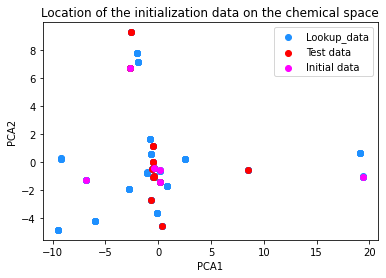

In [553]:
#pull the fingerprints of the initial data from the array

# initially I tried first getting the PCA for the initial data and then for the lookup data but this did not really work

'''
fingerprints_init = fingerprints_input[random_initialization]
print('Fingerprints_init shape:',fingerprints_init.shape)

# let's get the two principle components
pca_illustrate = PCA(n_components=2)
fingerprints_init_pca = pca_illustrate.fit_transform(fingerprints_init)
print('Fingerprints_init_pca shape:',fingerprints_init_pca.shape)

# let's get the fingerprints from the data of the lookup table together
fingerprints_lookupTable = np.delete(fingerprints_input, random_initialization, 0)
print('Fingerprints_lookupTable shape:',fingerprints_lookupTable.shape)

# let's get the two principle components
fingerprints_lookupTable_pca = pca_illustrate.fit_transform(fingerprints_lookupTable)
print('fingerprints_lookupTable_pca shape:',fingerprints_lookupTable_pca.shape)
'''

# Let's better get the first two principle components from the whole dataset and then take out the initial and lookup principal components
pca_illustrate = PCA(n_components=2)
fingerprints_pca_2 = pca_illustrate.fit_transform(full_dataset_input)
print(fingerprints_pca_2.shape)
fingerprints_pca_2 = np.array(fingerprints_pca_2)

#let's pull out the PC from the initial dataset
fingerprints_init_pca = fingerprints_pca_2[random_initialization]
print(fingerprints_init_pca.shape)
#print(fingerprints_init_pca)

# let's delete the initial data from the whole lookup table
fingerprints_lookupTable_pca = np.delete(fingerprints_pca_2, random_initialization, 0)
print(fingerprints_lookupTable_pca.shape)


# Let's get the plot ready
plt.title(label="Location of the initialization data on the chemical space")

plt.scatter(fingerprints_lookupTable_pca[:,0], fingerprints_lookupTable_pca[:,1],label='Lookup_data',color='dodgerblue')
plt.scatter(fingerprints_init_pca[6:,0],fingerprints_init_pca[6:,1] ,label='Test data',color='red')
plt.scatter(fingerprints_init_pca[:6,0],fingerprints_init_pca[:6,1] ,label='Initial data',color='fuchsia')



plt.xlabel('PCA1')
plt.ylabel('PCA2')

plt.legend()

print('is there something wrong, the PCA seems to no be able to separete the ')

## Let's train the initial random forest model

### 16 datapoints are selected for testing the model, those datapoints will be kept for model evaluation throughout the active learning, they remain fixed

(24,)
(24, 144)
Training Features Shape: (10, 144)
Training Labels Shape: (10,)
Testing Features Shape: (14, 144)
Testing Labels Shape: (14,)
Mean Absolute Error: 0.16543651845401244
Mean Squared Error: 0.03234303800066803
Root Mean Squared Error: 0.17984170261835278


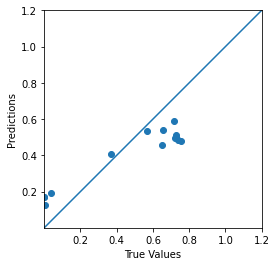

In [554]:
# Now let's train the initial RF

iniit_output = initial_data['Yield']
print(iniit_output.shape)

iniit_input = initial_data.drop(columns='Yield')
print(iniit_input.shape)

#train_features, test_features, train_labels, test_labels = train_test_split(iniit_input, iniit_output, test_size=0.7, random_state=1)
# we cannot use random allocation of train/test data, we need to specifically allocate the initial input in either the training or test partition
# the test partition will remain the 
#train_features_init = iniit_input[:6]
#train_labels_init = iniit_output[:6]
#test_features_init = iniit_input[6:]
#test_labels_init = iniit_output[6:]

train_features_init = iniit_input[14:]
train_labels_init = iniit_output[14:]
test_features_init = iniit_input[:14]
test_labels_init = iniit_output[:14]



#train_test_split(iniit_input, iniit_output, test_size=0.7, random_state=1)


print('Training Features Shape:', train_features_init.shape)
print('Training Labels Shape:', train_labels_init.shape)
print('Testing Features Shape:', test_features_init.shape)
print('Testing Labels Shape:', test_labels_init.shape)

regressor = RandomForestRegressor(n_estimators=200, random_state=0)
regressor.fit(train_features_init, train_labels_init)
test_predictions_init = regressor.predict(test_features_init)


# and evaluate it

a = plt.axes(aspect='equal')
plt.scatter(test_labels_init, test_predictions_init)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [1e-04,1.2]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

print('Mean Absolute Error:', metrics.mean_absolute_error(test_labels_init, test_predictions_init))
print('Mean Squared Error:', metrics.mean_squared_error(test_labels_init, test_predictions_init))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_labels_init, test_predictions_init)))

In [555]:
# Let's split the large dataset into the data which we will use for building the initial model
# and the data which we will keep aside as a look-up table
# note: the data is already shuffled

lookup_output = lookup_table['Yield']
print(lookup_output.shape)

lookup_input = lookup_table.drop(columns='Yield')
print(lookup_input.shape)


(163,)
(163, 144)


## Let's actually start the active learning

In [556]:
dataset_shape = []

RMSE = []

lookup_input = np.array(lookup_input)

lookup_output = np.array(lookup_output)

lookup_output = lookup_output.reshape(-1,1)

pred_yield_development = []

# set the very initial train features and labels
train_features = train_features_init
train_labels = train_labels_init

train_labels = np.array(train_labels).reshape(-1,1)

current_maximum =[]

#set back to 148 when done

for i in range (6):
    train_x = train_features 
    train_y = train_labels
    
    # let's train the RF
    regressor = RandomForestRegressor(n_estimators=200, random_state=0)
    regressor.fit(train_x, train_y)
    test_predictions = regressor.predict(test_features_init)
    
    # let's evaluate the RF
    rmse = metrics.mean_absolute_error(test_labels_init, test_predictions)
    RMSE.append(rmse)
    # print("RMSE of run",i,':',rmse)
    
    # append the current best datapoint to the table current_maximum
    current_maximum.append(np.max(train_labels))
    
    ''' inner loop for batch sampling '''
    
    next_batch = []
    
    single_yields = []
    
    # make a temporary copy of lookup input and output so that we can play around with that during batch sampling
    lookup_input_temp = lookup_input
    lookup_output_temp = lookup_output
    
    for x in range (25):
        
        # let's do predictions over the unexplored area and evaluate the best predictions
        lookup_predictions = regressor.predict(lookup_input_temp)

        # evaluate the highest predicted datapoint given the whole chemical space and the trained model
        best = np.max(lookup_predictions)

        # we have to create a list, otherwise we cannot find the index. With an Array it does not really work
        List = lookup_predictions.tolist()
        index = List.index(best)
        
        # we save the single indexes in the table 'next_batch'
        next_batch.append(index)
                
        # delete the datapoints from the temporary lookup table
        lookup_input_temp = np.delete(lookup_input_temp, index, 0)
        lookup_output_temp = np.delete(lookup_output_temp, index, 0)
        
        # let's just append the single yields to a table so that we can later evaluate the average yield of the batch
        single_yields.append(best)
        
        #print('Experiment:',x,'   ','index:',index,'   ','True yield:',best)
        
    # we need to reformate the batch of input and output data which we want to add to the training data     
    new_input = lookup_input[next_batch]
    new_output = lookup_output[next_batch]
    
    #print(new_output.shape,new_output)
    #print(train_labels.shape,train_labels)

    
    # now we know the index of the datapoint with the highest predicted yield and we want to add it to the training dataset
    train_features = np.append(train_features,new_input,axis=0)
    train_labels = np.append(train_labels,new_output,axis=0)

     # delete the datapoints from the lookup table
    lookup_input = np.delete(lookup_input, [next_batch], 0)
    lookup_output = np.delete(lookup_output, [next_batch], 0)
    
    # append the best predicted yield to the table pre_yield_development
    pred_yield_development.append(np.mean(single_yields))
    
    print('Batch:',i, '  the RMSE is:',rmse, '   average yield:',np.mean(single_yields))

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Batch: 0   the RMSE is: 0.16543651845401244    average yield: 0.5818817297321993


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Batch: 1   the RMSE is: 0.10162158633683725    average yield: 0.7660654493490725


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Batch: 2   the RMSE is: 0.0781909254497178    average yield: 0.7394366090808107


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Batch: 3   the RMSE is: 0.08638624774627424    average yield: 0.6937816454836152


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Batch: 4   the RMSE is: 0.08279467854791643    average yield: 0.7057187169314569


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Batch: 5   the RMSE is: 0.09555390411993955    average yield: 0.6427249046219481


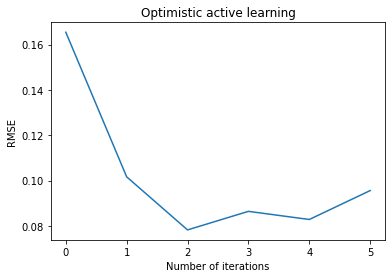

In [557]:
import matplotlib.pyplot as plt
plt.plot(RMSE)
plt.xlabel('Number of iterations')
plt.ylabel('RMSE')
plt.title(label="Optimistic active learning")
plt.show()

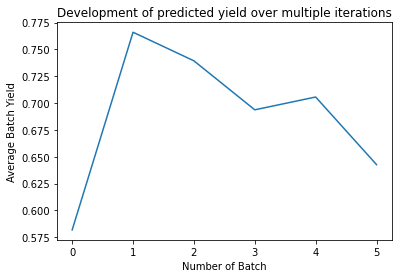

In [558]:
plt.plot(pred_yield_development)
plt.xlabel('Number of Batch')
plt.ylabel('Average Batch Yield')
plt.title(label="Development of predicted yield over multiple iterations")
plt.show()

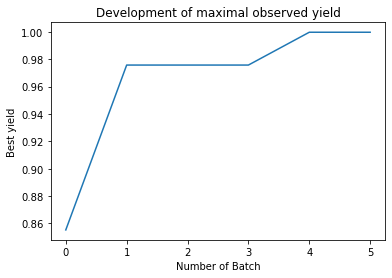

[0.8553018453399996, 0.9756929849874083, 0.9756929849874083, 0.9756929849874083, 0.9996579247288029, 0.9996579247288029]


In [559]:
plt.plot(current_maximum)
plt.xlabel('Number of Batch')
plt.ylabel('Best yield')
plt.title(label="Development of maximal observed yield")
plt.show()

print(current_maximum)